# Music genre prediction

## Описание  задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

## Описание данных

    instance_id - уникальный идентификатор трека  
    track_name - название трека  
    acousticness - акустичность   
    danceability - танцевальность  
    duration_ms -продолжительность в милисекундах  
    energy - энергичность  
    instrumentalness - инструментальность  
    key - базовый ключ (нота) произведения  
    liveness - привлекательность  
    loudness - громкость  
    mode - указывает на модальность (мажорную или минорную) трека  
    speechiness - выразительность  
    tempo - темп  
    obtained_date - дата загрузки в сервис  
    valence - привлекательность произведения для пользователей сервиса  
    music_genre - музыкальный жанр  

## Citation
Eduard Grigoryan, Eugene. (2023). Music genre prediction [M1_23DS+]. Kaggle. https://kaggle.com/competitions/music-genre-prediction-m1-23ds

Загрузим библиотеки

In [8]:
import pandas as pd
import numpy as np
import time
import seaborn as se
import matplotlib.pyplot as plt



#Метрики и оценки
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, \
                balanced_accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

#Работа с текстом
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD

#Модели
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#upsampling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE



#Phik
import random
import phik
from phik import resources, report
from phik.report import correlation_report, plot_correlation_matrix


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,  LabelEncoder, PowerTransformer, RobustScaler
from category_encoders import LeaveOneOutEncoder

#Модели для определения языка
from langdetect import detect, DetectorFactory, detect_langs
DetectorFactory.seed = 0
from guess_language import guess_language
import langid
import fasttext
model = fasttext.load_model('lid.176.bin')

import warnings
warnings.filterwarnings("ignore")

In [14]:
#Настройка графиков
se.set_style('darkgrid')
#%config InlineBackend.figure_formats = 'png' # svg Не работает :(
se.set(rc={'font.size': 8, 
           'figure.facecolor': 'white',
           'figure.figsize': (10, 6),
           'axes.edgecolor': 'black',
           'axes.facecolor': 'white',
           'axes.grid': True,
           'grid.color': 'black',
           'grid.linewidth': 0.5,
           'grid.alpha': 0.3,
           'grid.linestyle': '--',
           'text.color': 'black',
           'xtick.color': 'black',
           'ytick.color': 'black',
           'font.size': 10.0,
           'xtick.bottom': True,
           'xtick.top': False,
           'ytick.left': True,
           'ytick.right': True,
           'lines.linewidth': 1, 
           'patch.edgecolor': 'w',
           'lines.solid_capstyle': 'butt',
           'patch.linewidth': 0.2})

# EDA

## Загрузка и предварительный анализ данных

In [241]:
try:
    train_data = pd.read_csv("data/kaggle_music_genre_train.csv")
    test_data = pd.read_csv("data/kaggle_music_genre_test.csv")
except:
    print("Не удалось загрузить данные!!!")

In [243]:
train_data.head()

instance_id                  track_name  acousticness  danceability  \
0      25143.0                  Highwayman        0.4800         0.670   
1      26091.0       Toes Across The Floor        0.2430         0.452   
2      87888.0       First Person on Earth        0.2280         0.454   
3      77021.0  No Te Veo - Digital Single        0.0558         0.847   
4      20852.0             Chasing Shadows        0.2270         0.742   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0     182653.0   0.351          0.017600   D     0.115   -16.842  Major   
1     187133.0   0.670          0.000051   A     0.108    -8.392  Minor   
2     173448.0   0.804          0.000000   E     0.181    -5.225  Minor   
3     255987.0   0.873          0.000003  G#     0.325    -4.805  Minor   
4     195333.0   0.575          0.000002   C     0.176    -5.550  Major   

   speechiness    tempo obtained_date  valence  music_genre  
0       0.0463  101.384         4-Apr    0.450      Country  
1       0.0352  113.071         4-Apr    0.539         Rock  
2       0.3710   80.980         4-Apr    0.344  Alternative  
3       0.0804  116.007         4-Apr    0.966      Hip-Hop  
4       0.0487   76.494         4-Apr    0.583  Alternative

In [244]:
#Проверим, есть ли повторения среди id песен:
print("Являются ли значения id уникальными для всех строк:", len(train_data['instance_id'].unique()) == len(train_data))

Являются ли значения id уникальными для всех строк: True


### Название трека

Название трека может быть очень сильными признаком. Оно может много сказать о самой песне. Попробуем немного поисследовать этот признак. 

In [245]:
train_data['track_name'].tolist()

['Highwayman',
 'Toes Across The Floor',
 'First Person on Earth',
 'No Te Veo - Digital Single',
 'Chasing Shadows',
 'Eskimo Blue Day - Remastered',
 'Living On My Own',
 'Para Machuchar Meu Coracao',
 'In the Mood',
 '20.000 Volts',
 'Blessings',
 'Up Above My Head',
 'Witchy Woman - Eagles 2013 Remaster',
 'Iwanakutemo Tsutawaru Arewa Sukoshi Usoda - All Time Best Version',
 'School - Remastered',
 'Let Go Today',
 'Flying Saucer',
 'Muevelo',
 'Ill Ray (The King)',
 "That's What It's All About",
 'LVL',
 'Rebels - G-REX Remix',
 "Still Don't Give A Fuck",
 'Kindhearted Woman Blues',
 "Stroker's Theme",
 'X (with 2 Chainz & Saudi)',
 'Serenade in B flat, K.361 "Gran partita": 3. Adagio',
 'Samba Tranquille',
 'Real',
 'Money Don’t Change You',
 'Flare Guns',
 'Let Your Love Flow',
 'Wade in the Water - Live',
 "Country Boy's World",
 'Life Is Confusing',
 'Flodgin',
 'Dreaming with My Eyes Open',
 'Starfruit LA',
 'The Game',
 'No Less',
 'Down to Mexico',
 'Just A Friend',
 'Lost 

Предворительно можно получить следующие признаки:  

    1)Количество символов в названии  
    2)Количесвто слов
    3)Примерно определить язык названия
    4)Использовать CountVectorizer для определния частых слов
    5)Использовать TfidfVectorizer совместно с сингулярным разложением TSVD

Очистим названия от лишних символов

In [246]:
def track_name_cleaner(data):
    data['track_name'] = data['track_name'].str.replace('-', '')
    data['track_name'] = data['track_name'].str.replace('.', '')
    data['track_name'] = data['track_name'].str.replace('  ', ' ')
    data['track_name'] = data['track_name'].str.replace('(', '')
    data['track_name'] = data['track_name'].str.replace(')', '')
    data['track_name'] = data['track_name'].str.replace(':', '')
    data['track_name'] = data['track_name'].str.replace(',', '')
    data['track_name'] = data['track_name'].str.replace('&', '')
    data['track_name'] = data['track_name'].str.replace('/', '')
    data['track_name'] = data['track_name'].str.replace('?', '')
    return data

#### CountVectorizer

Попробуем определить, есть ли смысл использования CountVectorizer

In [20]:
CVec =  CountVectorizer(max_features=10, min_df=5, max_df=1.0, stop_words=['english']) 
track_name_features_cv = CVec.fit_transform(train_data['track_name']).toarray() 

In [21]:
target_ohe_for_headplot = pd.get_dummies(train_data['music_genre'])

<AxesSubplot:>

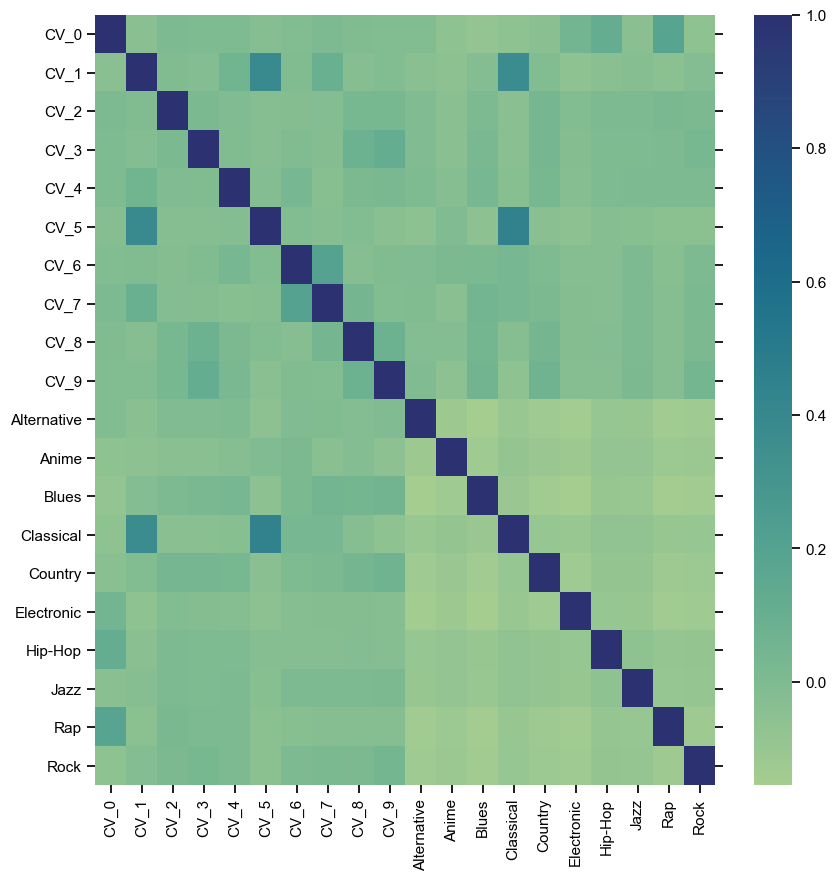

In [22]:
plt.subplots(figsize=(10, 10))
se.heatmap(pd.concat([pd.DataFrame(track_name_features_cv, columns=[f'CV_{i}' for i in range(10)]), 
                      target_ohe_for_headplot], axis=1).corr(), cmap="crest")

In [23]:
def generate_count_vectot_features(data, test, count=10):
    CVec =  CountVectorizer(max_features=count, min_df=5, max_df=1.0, stop_words=['english']) 
    data_cv = pd.DataFrame(CVec.fit_transform(data['track_name']).toarray(), columns=[f'CV_{i}' for i in range(count)] )
    test_cv = pd.DataFrame(CVec.transform(test['track_name']).toarray(), columns=[f'CV_{i}' for i in range(count)]  )
    
    data = pd.concat([data, data_cv], axis=1)
    test = pd.concat([test, test_cv], axis=1)
    return data, test

**Выводы**: 

Использование CountVectorizer вряд ли даст прирост в метрике, но может увеличить точность в определнии одного жанра в подходах один против всех или один против одного

#### TfidfTransformer and MultinomialNB

Построим вспомогательную модель для определния жанра по названию трека. Это может дать дополнительный прирост в точности. Но необходимо быть аккуратными и применить метод так, чтобы он не дал переобучения для тренировочной выборки. 

In [297]:
#Возвращает столбец с предсказаниями жанра для test, обученный по train, target
def Tfidf_NB(train, target, test):
    train = track_name_cleaner(train)
    test = track_name_cleaner(test)
    
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(train['track_name'])
    test_counts = count_vect.transform(test['track_name'])
    
    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(train_counts)
    test_tfidf = tfidf_transformer.transform(test_counts)

    clf = MultinomialNB().fit(train_tfidf, target['music_genre'])
    pred = pd.DataFrame(clf.predict(test_tfidf))
    pred.columns = ['Tfidf_NB']
    return pred

In [304]:
pred = Tfidf_NB(train_data[:5000], train_data[:5000], train_data[5000:])

In [306]:
ans = 0
for i in range(len(pred)):
    if pred.iloc[i][0] == train_data[5000:].iloc[i]['music_genre']:
        ans+=1
        
round(ans/len(pred), 3)

0.249

#### TfidfVectorizer and TSVD

Векторизация  и уменьшение размерности

In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_data['track_name'])

In [26]:
tsvd = TruncatedSVD(3, algorithm ='arpack')
a = tsvd.fit_transform(X)
a.shape

(20394, 3)

(-0.4, 0.6)

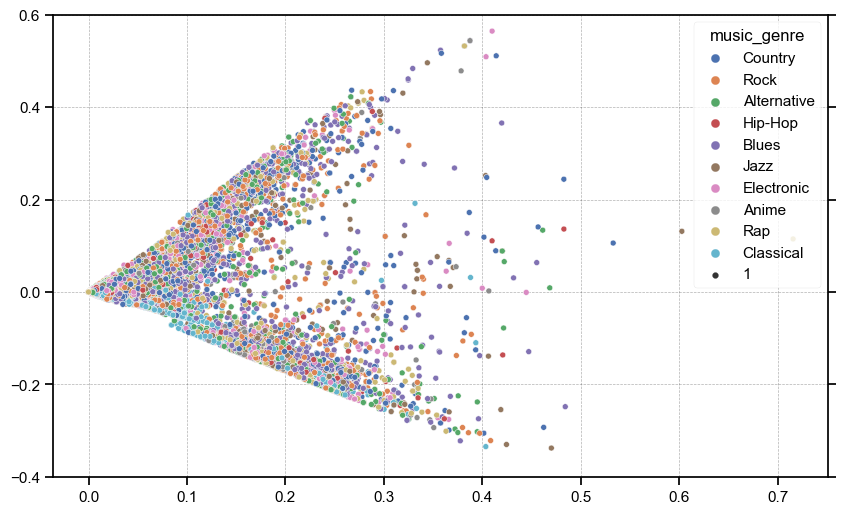

In [27]:
se.scatterplot(x=a[:,0], y=a[:,1], hue=train_data['music_genre'], size=1)
plt.ylim(-0.4, 0.6)

In [28]:
def TfV_TSVD_features(data, test, count=3):
    vectorizer = TfidfVectorizer()
    new_features_data_tfv = vectorizer.fit_transform(data['track_name'])
    new_features_test_tfv = vectorizer.transform(test['track_name'])
    
    tsvd = TruncatedSVD(3, algorithm ='arpack')
    new_features_data = pd.DataFrame(tsvd.fit_transform(new_features_data_tfv))
    new_features_test = pd.DataFrame(tsvd.transform(new_features_test_tfv))
    new_features_data.columns = [f'TfV_TSVD_{i}' for i in range(count)]
    new_features_test.columns = [f'TfV_TSVD_{i}' for i in range(count)]
    
    data = pd.concat([data, new_features_data], axis=1)
    test = pd.concat([test, new_features_test], axis=1)
    
    return data, test

#### TfV_TSVD_KMean

Кластеризация предыдущего пункта

In [29]:
def TfV_TSVD_kmean(data, test, n_clust = 20):
    columns = [col for col in data.columns if 'TfV_TSVD' in col]
    
    kmean = KMeans(n_clusters=n_clust, random_state=42)

    data_clust = pd.DataFrame(kmean.fit_predict(data[columns]), columns = ['kmean_TfV_TSVD'])
    test_clust = pd.DataFrame(kmean.predict(test[columns]), columns = ['kmean_TfV_TSVD'])

    data = data.join(data_clust, how='outer')
    test = test.join(test_clust, how='outer')
    
    data.columns = data.columns.astype(str)
    test.columns = test.columns.astype(str)

    return data, test

#### Определение языка

In [31]:
def upgrade_detect(x):
    try:
        return detect(x)
    except:
        return 'UNKNOWN'

In [32]:
def updrade_langid(x):
    return langid.classify(x)[0]

In [33]:
def fast_text(x):
    return model.predict(x)[0][0][-2:]

In [34]:
def detect_language(data):
    language = pd.DataFrame()
    language['langdetect_detect'] = data['track_name'].apply(upgrade_detect)
    language['guess_language'] = data['track_name'].apply(guess_language)
    language['updrade_langid'] = data['track_name'].apply(updrade_langid)
    language['fast_text'] = data['track_name'].apply(fast_text)
    
    language = language.mode(axis=1)
    language.loc[language.isna().sum(axis=1) == 0, 0] = 'UNKNOWN'
    
    language.drop(columns=[1,2,3], inplace=True)
    
    
    le = LabelEncoder()
    language = pd.DataFrame(le.fit_transform(language))
    language.columns = ['language']
    
    return pd.concat([data, language], axis=1)

### Признак **obtained_date**

In [23]:
train_data['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

Максимально неинформативный признак, в финальном датасете он участвовать не будет. Долой его.

In [8]:
train_data.drop(columns=['obtained_date'], inplace = True)
test_data.drop(columns=['obtained_date'], inplace = True)

Это неинформатиынй признак, удалим его

### Категориальные и числовые признаки

Сразу можно сказать, что есть категориальные и числовые признаки.  

**Категориальные**:  
    key, mode
    
**Числовые**:  
        acousticness, danceability, duration_ms, energy, instrumentalness, liveness,
       loudness, speechiness, tempo, valence
       
**Целевой признак**:  
        music_genre

In [9]:
#Пердворительно признаки для обучения
good_features = ['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'valence',
       'music_genre']

In [10]:
#Числовые признаки
num_features = ['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness',  'liveness',
       'loudness', 'speechiness', 'tempo', 'valence']
#Категориальные признаки
cat_features = ['key', 'mode']

### Целевой признак

In [11]:
train_data['music_genre'].unique()

array(['Country', 'Rock', 'Alternative', 'Hip-Hop', 'Blues', 'Jazz',
       'Electronic', 'Anime', 'Rap', 'Classical'], dtype=object)

In [12]:
balance_genres = train_data.groupby('music_genre')['instance_id'].count()
print("Процентное соотношение целевого признака в обучающем наборе:")
pd.DataFrame(balance_genres/len(train_data)*100).round(3).rename(columns={'instance_id': 'Процент данных'}) 

Процентное соотношение целевого признака в обучающем наборе:


Процент данных
music_genre                
Alternative          12.754
Anime                 9.321
Blues                14.014
Classical             6.732
Country              10.395
Electronic           12.572
Hip-Hop               5.614
Jazz                  6.075
Rap                  11.905
Rock                 10.616

### Ящик с усами

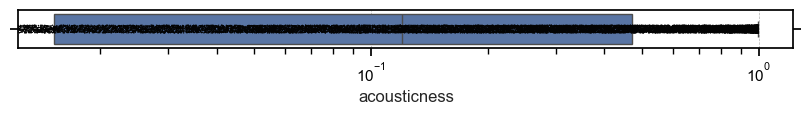

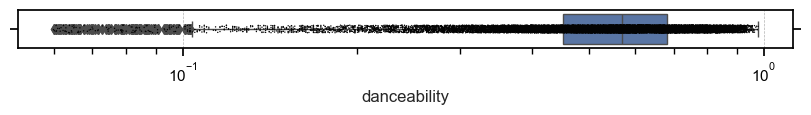

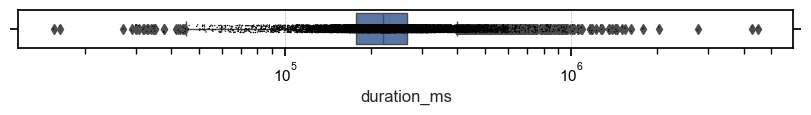

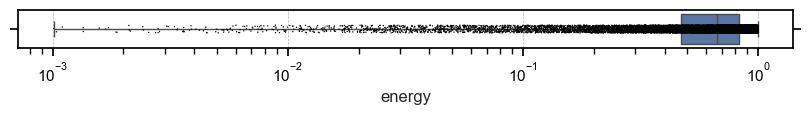

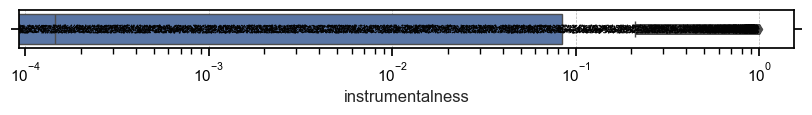

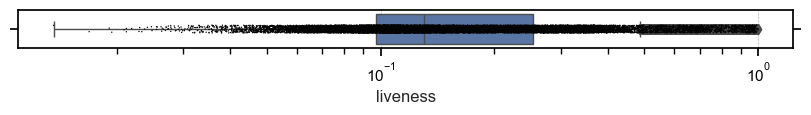

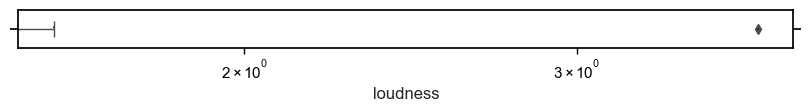

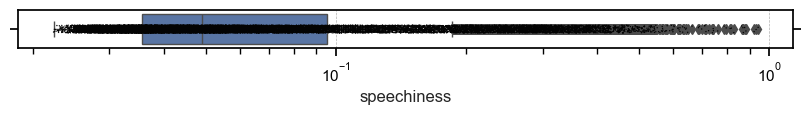

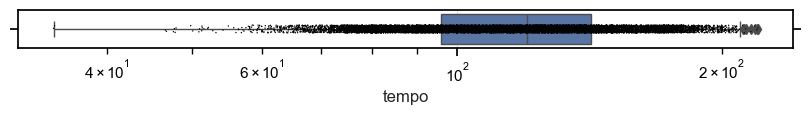

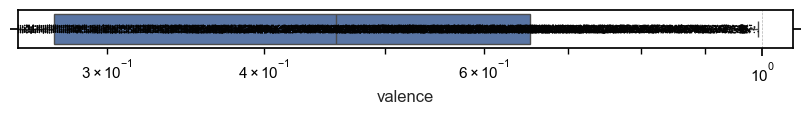

In [13]:
for i in num_features:
    f, ax = plt.subplots(figsize=(10, 0.5))
    ax.set_xscale("log")
    se.boxplot(x=i, data=train_data, ax=ax,  orient='h')
    se.stripplot(x=i, data=train_data, ax=ax,
              size=1, color=".01", linewidth=0)

Признак **loudness** показал странный результат. Посмотрим:

<AxesSubplot:>

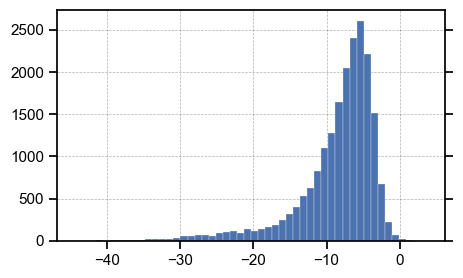

In [36]:
train_data['loudness'].hist(figsize=(5,3), bins=50)

Всё встало на свои места, log scale не работает в отрицательном диапазоне. На вский случай посмотрим на минимальние и максимальные значения по всем признакам.

In [15]:
train_data.describe()

instance_id  acousticness  danceability   duration_ms        energy  \
count  20394.000000  20394.000000  20394.000000  2.039400e+04  20394.000000   
mean   55973.846916      0.274783      0.561983  2.203754e+05      0.625276   
std    20695.792545      0.321643      0.171898  1.267283e+05      0.251238   
min    20011.000000      0.000000      0.060000 -1.000000e+00      0.001010   
25%    38157.250000      0.015200      0.451000  1.775170e+05      0.470000   
50%    56030.000000      0.120000      0.570000  2.195330e+05      0.666000   
75%    73912.750000      0.470000      0.683000  2.660000e+05      0.830000   
max    91758.000000      0.996000      0.978000  4.497994e+06      0.999000   

       instrumentalness      liveness      loudness   speechiness  \
count      20394.000000  20394.000000  20394.000000  20394.000000   
mean           0.159989      0.198540     -8.552998      0.091352   
std            0.306503      0.166742      5.499917      0.097735   
min            0.000000      0.013600    -44.406000      0.022300   
25%            0.000000      0.097300    -10.255750      0.035600   
50%            0.000144      0.130000     -7.052000      0.049050   
75%            0.084475      0.253000     -5.054000      0.095575   
max            0.996000      1.000000      3.744000      0.942000   

              tempo       valence  
count  19952.000000  20394.000000  
mean     120.942522      0.464588  
std       30.427590      0.243387  
min       34.765000      0.000000  
25%       95.921750      0.272000  
50%      120.012500      0.457000  
75%      141.966250      0.653000  
max      220.041000      0.992000

**Вывод**  
Ящик с усами показал, что в признаке **duration_ms** есть песни продолжительностью 74 минуты, а также со значениями -1, чего не может быть. Необходимо изучить это отдельно.

### Признак duration_ms

In [16]:
bad_data = train_data.query('duration_ms == -1')
print("Размер неполных данных", bad_data.shape)
bad_data.head()

Размер неполных данных (2009, 15)


instance_id                                         track_name  \
13      73565.0  Iwanakutemo Tsutawaru Arewa Sukoshi Usoda - Al...   
26      87453.0  Serenade in B flat, K.361 "Gran partita": 3. A...   
35      76827.0                                            Flodgin   
50      43888.0                              Things My Father Said   
55      39574.0  Fidelio, Op. 72, Act I: Ha! Welch ein Augenbli...   

    acousticness  danceability  duration_ms  energy  instrumentalness  key  \
13        0.1100         0.470         -1.0  0.6410          0.000000   F#   
26        0.9910         0.154         -1.0  0.0384          0.902000  NaN   
35        0.0848         0.748         -1.0  0.7120          0.000000    D   
50        0.0540         0.482         -1.0  0.6270          0.000003    D   
55        0.9090         0.374         -1.0  0.2270          0.000069   A#   

    liveness  loudness   mode  speechiness    tempo  valence  music_genre  
13     0.155    -7.454  Major       0.0658   86.387   0.6380        Anime  
26     0.109   -26.909  Major       0.0405   68.199   0.0393    Classical  
35     0.132    -5.651  Major       0.1430  140.055   0.1800          Rap  
50     0.111    -5.779  Major       0.0300   95.903   0.1700  Alternative  
55     0.686   -18.719  Major       0.0579   78.236   0.2640    Classical

Как оказалось, в существенной части данных отсутствует длина трека. Возможны три пути:  
        1)Заглушка на эти пропуски (оставить -1)  
        2)Парсинг  
        3)Не использовать данные для обучения  

In [17]:
train_data.sort_values(by='duration_ms', ascending = False).head()

instance_id                                         track_name  \
20117      31587.0                           Late Night Tales: Bonobo   
4502       33452.0                                         Mixtape 13   
8222       68269.0                                           45:33:00   
10699      44557.0  Mountain Jam (Theme From “First There Is A Mou...   
6343       33672.0  Symphony No. 6 in A Minor: 4. Finale (Allegro ...   

       acousticness  danceability  duration_ms  energy  instrumentalness key  \
20117       0.52800         0.408    4497994.0   0.436            0.0995   E   
4502        0.00299         0.366    4276000.0   0.778            0.0697   D   
8222        0.13800         0.478    2764934.0   0.897            0.6570   G   
10699       0.12300         0.332    2019293.0   0.741            0.7050  F#   
6343        0.94400         0.160    1778440.0   0.353            0.9020  A#   

       liveness  loudness   mode  speechiness    tempo  valence music_genre  
20117    0.1980   -11.497  Minor       0.1640   76.868   0.0778  Electronic  
4502     0.0954    -4.126  Major       0.0622  138.293   0.1470  Electronic  
8222     0.1000    -6.554  Major       0.0471  113.018   0.1860  Electronic  
10699    0.9420   -10.472  Minor       0.0535      NaN   0.2590       Blues  
6343     0.1050   -10.529  Major       0.0336   83.867   0.0716   Classical

In [18]:
train_data.query('duration_ms > 0').sort_values(by='duration_ms', ascending = True).head()

instance_id                                         track_name  \
4036       53111.0  Rinaldo, HWV 7a, Act I (Ed. G. Sechi): Questi ...   
3352       41093.0  St. John Passion, BWV 245, Pt. 2: No. 25c, Pil...   
11048      88575.0  Rinaldo, HWV 7a, Act II (Ed. G. Sechi): Esser ...   
11977      34105.0  Preludes, Op. 28: No. 10 in C-Sharp Minor (All...   
5946       34918.0                                     Gohan Vs. Cell   

       acousticness  danceability  duration_ms  energy  instrumentalness key  \
4036        0.96900         0.562      15509.0  0.1250           0.00138   B   
3352        0.91400         0.588      16316.0  0.1650           0.00000   D   
11048       0.96900         0.615      27179.0  0.1530           0.00000   B   
11977       0.99000         0.367      29040.0  0.0316           0.93900  F#   
5946        0.00291         0.338      30027.0  0.6310           0.86600   D   

       liveness  loudness   mode  speechiness    tempo  valence music_genre  
4036      0.373   -15.449  Minor       0.2010  115.827    0.574   Classical  
3352      0.233   -26.286  Major       0.2370  104.678    0.000   Classical  
11048     0.852   -20.561  Minor       0.4980   71.540    0.386   Classical  
11977     0.110   -31.053  Minor       0.0395  132.872    0.570   Classical  
5946      0.143    -7.465  Minor       0.0426  126.200    0.468       Anime

In [19]:
train_data = train_data.query('duration_ms < 2000000')

In [20]:
train_data.columns

Index(['instance_id', 'track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'music_genre'],
      dtype='object')

In [21]:
train_data.shape

(20390, 15)

По правилам длинные композицииявляются выбросами, и могут повлиять на рещультаты масштабирования. Заодно отмасштабирую эти признаки

### Создание новых признаков

speechiness - выразитьельность, или же всё таки красноречивость?

In [ ]:
speech = ['Musical', 'Mix_music_speech', 'Speech']
speech_bins = [train_data['speechiness'].min(), 0.33, 0.66, train_data['speechiness'].max()]

train_data['speechiness_type'] = pd.cut(train_data['speechiness'], bins=speech_bins,
                            labels=speech, right=True, include_lowest=True)

test_data['speechiness_type'] = pd.cut(test_data['speechiness'], bins=speech_bins,
                            labels=speech, right=True, include_lowest=True)

valence - привлекательность произведения для пользователей сервиса. Звучит как популярность. Меня начинает смущать описание признаков. 

In [ ]:
mood_labels = ['Sad', 'Normal', 'Happy']
colToBin = df['valence']
mood_bins = [colToBin.min(), colToBin.quantile(0.25), colToBin.quantile(0.75), colToBin.max()]

#Изменим mode на modality, по смыслу так лучше
df.rename(columns={'mode': 'modality'}, inplace=True)

df['mood'] = pd.cut(df['valence'], bins=mood_bins, labels=mood_labels, right=True, include_lowest=True)

### Scaler

In [22]:
scale = StandardScaler()

train_data[['duration_ms', 'tempo']] = scale.fit_transform(train_data[['duration_ms', 'tempo']])
test_data[['duration_ms', 'tempo']] = scale.transform(test_data[['duration_ms', 'tempo']])

### Корреляция phik

In [8]:
def phik_help(df):  
    
    # матрица корреляции признаков
    interval_cols = df.select_dtypes('number').columns.tolist()
    phik_overview = df.phik_matrix(interval_cols=interval_cols)
    
    plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1,
                        figsize=(15,15))

    # статистическая значимость зависимостей
    significance_overview = df.significance_matrix(interval_cols=interval_cols)
    
    plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1,
                        figsize=(15,15))

    # глобальный коэффициент корреляции
#     global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

    
#     plot_correlation_matrix(global_correlation, 
#                             x_labels=[''], y_labels=global_labels, 
#                             color_map="Greens", title=r"$g_k$",
#                             fontsize_factor=1,
#                             figsize=(5,3))

In [10]:
a = pd.concat([train_data[:10000].drop(columns='music_genre'), pd.get_dummies(train_data[:10000]['music_genre'])], axis=1)

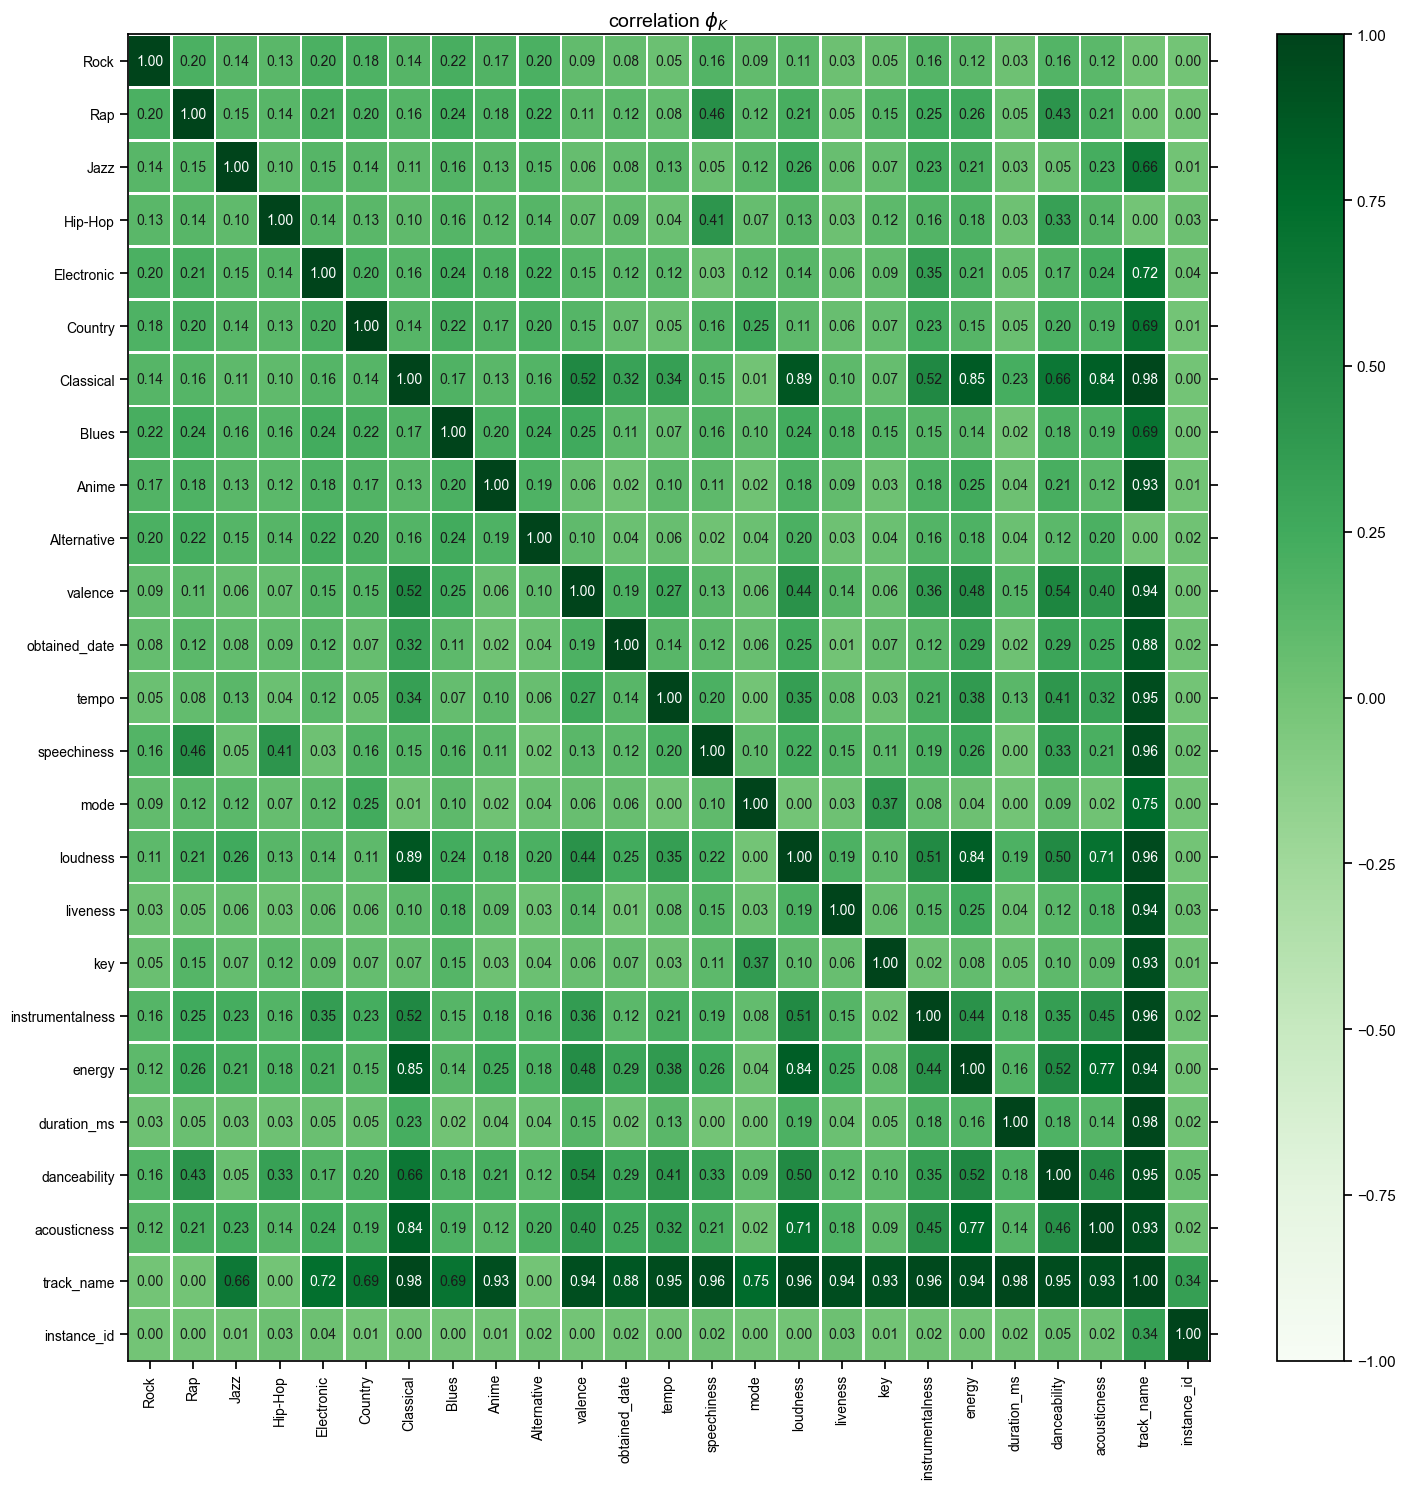

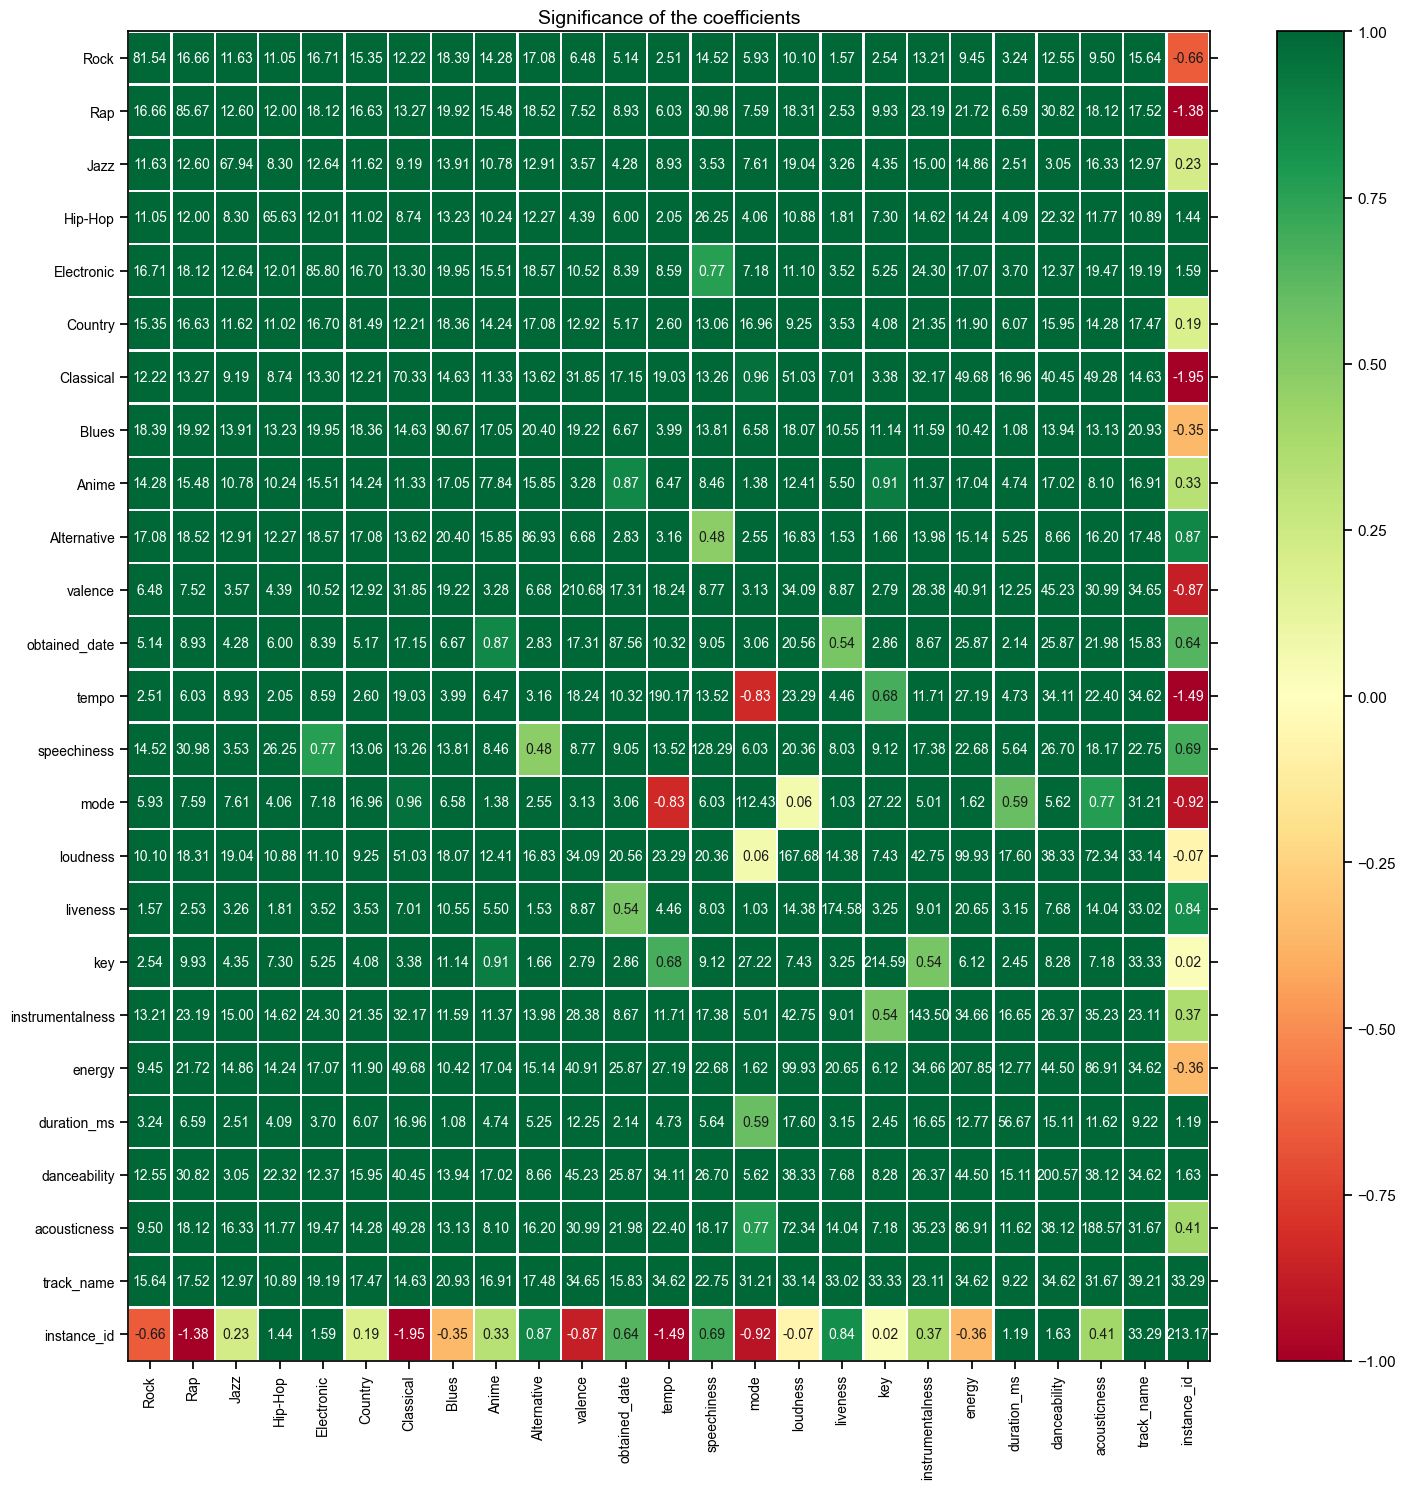

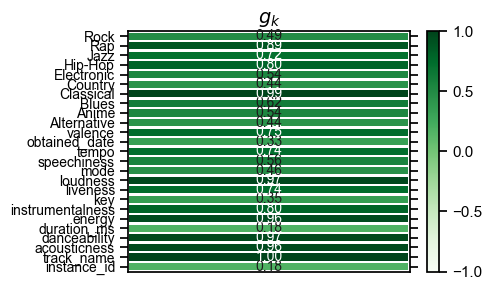

In [11]:
phik_help(a)

### Пропуски

Проверим данные на пропуски:

In [25]:
train_data.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               441
valence               0
music_genre           0
dtype: int64

Признаки key и mode являются категориальными признаками, поэтому поставить на них "заглушку" может быть хорошей идеей. А вот признак tempo может быть очень важной характеристикой жанра. Выберем хорошо коррелирующие признаки, сгрупируем по ним и возьмём среднее значение. 

In [26]:
#Пересечения NaN в двух стоолбцах
train_data.loc[(train_data['mode'].isna()) & (train_data['key'].isna())].shape

(22, 15)

In [27]:
for key in train_data['key'].unique():
    if not pd.isnull(key):
        popular = train_data[(train_data['key'] == key) & ~(train_data['mode'].isna())]['mode'].mode()[0]
        train_data.loc[(train_data['key'] == key) & (train_data['mode'].isna()), 'mode'] = popular
        test_data.loc[(test_data['key'] == key) & (test_data['mode'].isna()), 'mode'] = popular

In [28]:
for mode in train_data['mode'].unique():
    if not pd.isnull(mode):
        popular = train_data[(train_data['mode'] == mode) & ~(train_data['key'].isna())]['key'].mode()[0]
        train_data.loc[(train_data['mode'] == mode) & (train_data['key'].isna()), 'key'] = popular
        test_data.loc[(test_data['mode'] == mode) & (test_data['key'].isna()), 'key'] = popular

In [29]:
train_data['key'] = train_data['key'].fillna('unknown_key')
train_data['modality'] = train_data['modality'].fillna('unknown_modality')

test_data['key'] = test_data['key'].fillna('unknown_key')
test_data['modality'] = test_data['modality'].fillna('unknown_modality')

Лучшими признаками по корреляции являются **danceability** и **energy**. В обоих признаках значения отнорированы и лежат в интервале [0, 1]. Категоризируем эти признаки и заполним пропуски медианой. 

In [30]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['E_dance', 'D_dance', 'C_dance', 'B_dance', 'A_dance']
train_data['danceability_category'] = pd.cut(train_data.danceability, bins=bins, labels=labels, right = True)
test_data['danceability_category'] = pd.cut(test_data.danceability, bins=bins, labels=labels, right = True)

In [31]:
labels = ['E_energy', 'D_energy', 'C_energy', 'B_energy', 'A_energy']
train_data['energy_category'] = pd.cut(train_data.energy, bins=bins, labels=labels, right = True)
test_data['energy_category'] = pd.cut(test_data.energy, bins=bins, labels=labels, right = True)

In [32]:
train_data.groupby('danceability_category')['tempo'].agg(['mean', 'median', 'count'])

mean    median  count
danceability_category                           
E_dance               -0.575184 -1.151708    556
D_dance                0.172255  0.222128   2897
C_dance                0.100406  0.130434   7943
B_dance               -0.109119 -0.097520   6953
A_dance               -0.136277 -0.098029   1600

In [33]:
train_data.groupby('energy_category')['tempo'].agg(['mean', 'median', 'count'])

mean    median  count
energy_category                           
E_energy        -0.619351 -0.859601   1619
D_energy        -0.199976 -0.248470   2173
C_energy        -0.086357 -0.096205   4385
B_energy         0.023785 -0.030113   5888
A_energy         0.284825  0.233762   5884

In [34]:
for dance_category in train_data['danceability_category'].unique():
    for en_category in train_data['energy_category'].unique():
        median = train_data[(train_data.danceability_category == dance_category) & \
                            (train_data.energy_category == en_category)]['tempo'].median()
        train_data.loc[((train_data.danceability_category == dance_category) & \
                            (train_data.energy_category == en_category) & \
                        (train_data.tempo.isna())), 'tempo'] = median
        test_data.loc[((test_data.danceability_category == dance_category) & \
                    (test_data.energy_category == en_category) & \
                (test_data.tempo.isna())), 'tempo'] = median

Проверим

In [35]:
train_data.isna().sum()

instance_id              0
track_name               0
acousticness             0
danceability             0
duration_ms              0
energy                   0
instrumentalness         0
key                      0
liveness                 0
loudness                 0
mode                     0
speechiness              0
tempo                    0
valence                  0
music_genre              0
danceability_category    0
energy_category          0
dtype: int64

In [36]:
test_data.isna().sum()

instance_id              0
track_name               0
acousticness             0
danceability             0
duration_ms              0
energy                   0
instrumentalness         0
key                      0
liveness                 0
loudness                 0
mode                     0
speechiness              0
tempo                    0
valence                  0
danceability_category    0
energy_category          0
dtype: int64

### Реализация функций

Пропуски, аномальные значения есть как в тренировочном датасете, так и в тестовов. Поэтому необходим хороший метод для чистки данных. Для автоматизации всего процесса реализуем алгоритм преобработки данных при её загрузке

In [3]:
def upload_data():
    try:
        train = pd.read_csv("data/kaggle_music_genre_train.csv")
        test = pd.read_csv("data/kaggle_music_genre_test.csv")
        train = track_name_cleaner(train)
        test = track_name_cleaner(test)
        return train, test
    except:
        print("Не удалось загрузить данные!!!")
        return -1
    

def binningFeatures(df):
    speech_labels = ['OnlyMusic', 'OnlyMusic_Mix', 'Mix', 'Mix_Speech', 'Speech']
    speech_bins = [0, 0.2, 0.4, 0.60, 0.8, 1]
    df['speechiness_type'] = pd.cut(df['speechiness'], bins=speech_bins, labels=speech_labels, right=True, include_lowest=True)
    
    mood_labels = ['plak_plak', 'Sad', 'Normal', 'Happy', 'Get_High']
    mood_bins = [0, 0.2, 0.4, 0.60, 0.8, 1]
    df['mood'] = pd.cut(df['valence'], bins=mood_bins, labels=mood_labels, right=True, include_lowest=True)
    
    liveness_labels = ['very_boring', 'boring', 'Normal', 'popular' , 'very_popular']
    mood_bins = [0, 0.2, 0.4, 0.60, 0.8, 1]
    df['liveness_type'] = pd.cut(df['valence'], bins=mood_bins, labels=mood_labels, right=True, include_lowest=True)
    
    
    
    return df


def makeNewFeatures(df):
    df.rename(columns={'mode': 'modality'}, inplace=True)
    df = binningFeatures(df)
    
    df['instrumental'] = np.where(df['instrumentalness'] > 0.5, 1, 0)
    #df['live'] = np.where(df['liveness'] > 0.5, 1, 0)
    df['track_name_lenght'] = df['track_name'].apply(len)
    df['track_name_words'] = df['track_name'].str.split().str.len()
    
    df.drop(columns=['obtained_date'], inplace = True)
    return df



def clean_data(df):
    df.loc[df['duration_ms'] == -1, 'duration_ms'] = df[df['duration_ms'] > 0].median()
    low, high = df['duration_ms'].quantile([0.01, 0.99])
    mask = df[col].between(low, high)
    df = df[mask]
    return df

def null_input(train, test):
    
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
    labels = ['E_dance', 'D_dance', 'C_dance', 'B_dance', 'A_dance']
    train['danceability_category'] = pd.cut(train.danceability, bins=bins, labels=labels, right = True)
    test['danceability_category'] = pd.cut(test.danceability, bins=bins, labels=labels, right = True)
    
    labels = ['E_energy', 'D_energy', 'C_energy', 'B_energy', 'A_energy']
    train['energy_category'] = pd.cut(train.energy, bins=bins, labels=labels, right = True)
    test['energy_category'] = pd.cut(test.energy, bins=bins, labels=labels, right = True)
    
    for dance_category in train['danceability_category'].unique():
        for en_category in train['energy_category'].unique():
            median = train[(train.danceability_category == dance_category) & \
                                (train.energy_category == en_category)]['tempo'].median()
            train.loc[((train.danceability_category == dance_category) & \
                                (train.energy_category == en_category) & \
                            (train.tempo.isna())), 'tempo'] = median
            test.loc[((test.danceability_category == dance_category) & \
                        (test.energy_category == en_category) & \
                    (test.tempo.isna())), 'tempo'] = median
            
    for en_category in train['energy_category'].unique():
        median = train[train.energy_category == en_category]['loudness'].median()
        train.loc[(train.energy_category == en_category), 'loudness/energy'] = median
        test.loc[(test.energy_category == en_category), 'loudness/energy'] = median    
    
    
    for cat_liveness_type in train['liveness_type'].unique():
        median = train[train.liveness_type == cat_liveness_type]['loudness'].median()
        train.loc[(train.liveness_type == cat_liveness_type), 'loudness/liveness'] = median
        test.loc[(test.liveness_type == cat_liveness_type), 'loudness/liveness'] = median   
        
    for energy_type in train['energy_category'].unique():
        median = train[train['energy_category'] == energy_type]['danceability'].median()
        train.loc[(train['energy_category'] == energy_type), 'danceability/energy'] = median
        test.loc[(test['energy_category'] == energy_type), 'danceability/energy'] = median  
    
    global cat_features
    cat_features.append('energy_category')
    cat_features.append('danceability_category')
    cat_features.append('loudness/liveness')
    cat_features.append('loudness/energy')
    cat_features.append('danceability/energy')
    
    #Пропуски key и modality
    train['key'] = train['key'].fillna('unknown_key')
    train['modality'] = train['modality'].fillna('unknown_modality')

    test['key'] = test['key'].fillna('unknown_key')
    test['modality'] = test['modality'].fillna('unknown_modality')
    
    return train, test

num_features = []
cat_features = []
skewedFeatures = []

def update_columns_classes():
    global num_features, cat_features, skewedFeatures
    
    num_features = ['acousticness', 'danceability',
           'duration_ms', 'energy', 'instrumentalness', 'liveness',
           'loudness', 'speechiness', 'tempo', 'valence',
           'track_name_lenght', 'track_name_words', 'instrumental']

    cat_features = [ 'modality', 'key']

    skewedFeatures = ['duration_ms', 'speechiness', 'liveness', 'track_name_lenght', 'track_name_words',
     'instrumentalness', 'acousticness', 'loudness']


def add_kmean(train, test):

    kmean = KMeans(n_clusters=40, random_state=42)

    train_class = pd.DataFrame(kmean.fit_predict(train[num_features]), columns = ['kmean'])
    test_class = pd.DataFrame(kmean.predict(test[num_features]), columns = ['kmean'])

    train = train.join(train_class, how='outer')
    test = test.join(test_class, how='outer')
    
    train.columns = train.columns.astype(str)
    test.columns = test.columns.astype(str)
    
    num_features.append('kmean')
    return train, test

def add_birch(train, test):
    brc = Birch(n_clusters=40) 
    train_class = pd.DataFrame(brc.fit_predict(train[num_features]), columns = ['Birch'])
    test_class = pd.DataFrame(brc.predict(test[num_features]), columns = ['Birch'])

    train = train.join(train_class, how='outer')
    test = test.join(test_class, how='outer')

    train.columns = train.columns.astype(str)
    test.columns = test.columns.astype(str)
    num_features.append('Birch')
    return train, test

def get_good_data():
    train, test = upload_data()
    
    #Згружаем списки с названиями признаков
    update_columns_classes()
    
    #Новые признаки и разделяем на датасеты
    train = makeNewFeatures(train)
    test = makeNewFeatures(test)
    
    global cat_features
    cat_features.append('liveness_type')
    cat_features.append('speechiness_type')
    cat_features.append('mood')
    
    target = train['music_genre']
    train.drop(columns='music_genre', inplace = True)

    #Чистим промуски
    train, test = null_input(train, test)
    
    #train, test = TfV_TSVD_features(train, test, count=3)
    
    #train, test = TfV_TSVD_kmean(train, test, n_clust = 20)
    
    #train, test = add_kmean(train, test)
    #train, test = add_birch(train, test)
    
    #Добавляем ещё признаки связанные с названием
    #train, test = generate_count_vectot_features(train, test, count=5)
    train = detect_language(train)
    test = detect_language(test)

    #Кодируем признаки
    labelencoder = LabelEncoder()
    target = labelencoder.fit_transform(target)
    
    return train.drop(columns = 'instance_id'), pd.DataFrame(target), test, labelencoder

def use_upscaling(data, target):
    if type(target) == np.ndarray:
        target = pd.DataFrame(target)
        
    smote = SMOTE(random_state=42, k_neighbors=20)
    data_SMOTE, train_SMOTE = smote.fit_resample(data.values, target.values)  

    data = pd.concat([data, pd.DataFrame(data_SMOTE, columns = data.columns)])
    target = pd.concat([target, pd.DataFrame(train_SMOTE, columns = target.columns)])

    data.reset_index(drop=True, inplace=True)
    target.reset_index(drop=True, inplace=True)  

    return data, target

In [4]:
#Загружем данные и создаем доп признаки
train, target, test, labelencoder = get_good_data()

Не удалось загрузить данные!!!


TypeError: cannot unpack non-iterable int object

In [7]:
#Кодировщики
le = LabelEncoder()
looe = LeaveOneOutEncoder()
pt = PowerTransformer(copy=False)
rs = RobustScaler()

NameError: name 'RobustScaler' is not defined

In [322]:
for col in cat_features:
    train[col]  = le.fit_transform(train[col])
    test[col]  = le.transform(test[col])
    
target = le.fit_transform(target)

train['track_name_looe']= looe.fit_transform(train['track_name'], target)
test['track_name_looe']= looe.transform(test['track_name'])

In [323]:
train[skewedFeatures] = pt.fit_transform(train[skewedFeatures])
test[skewedFeatures] = pt.transform(test[skewedFeatures])

In [324]:
train[skewedFeatures] = rs.fit_transform(train[skewedFeatures])
test[skewedFeatures] = rs.transform(test[skewedFeatures])

In [59]:
train.drop(columns='track_name', inplace=True)

LinAlgError: singular matrix

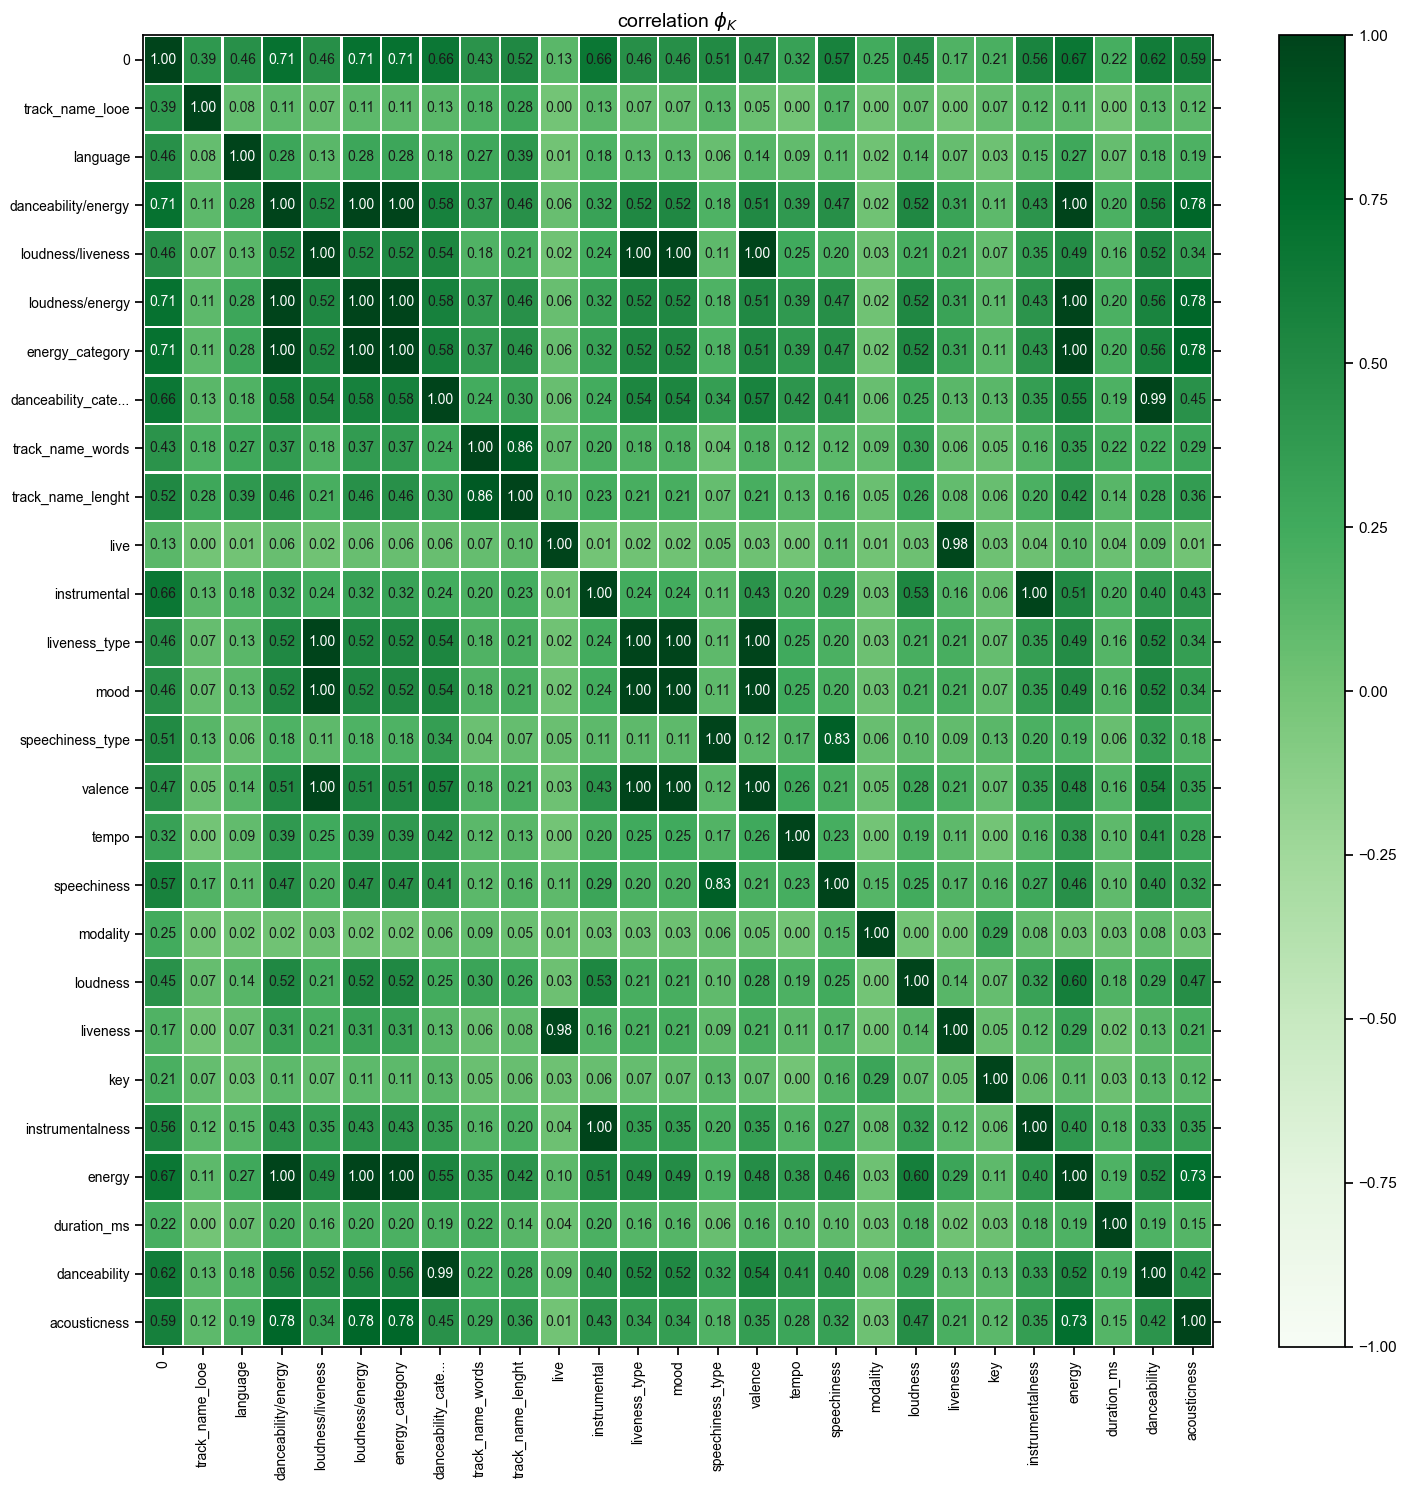

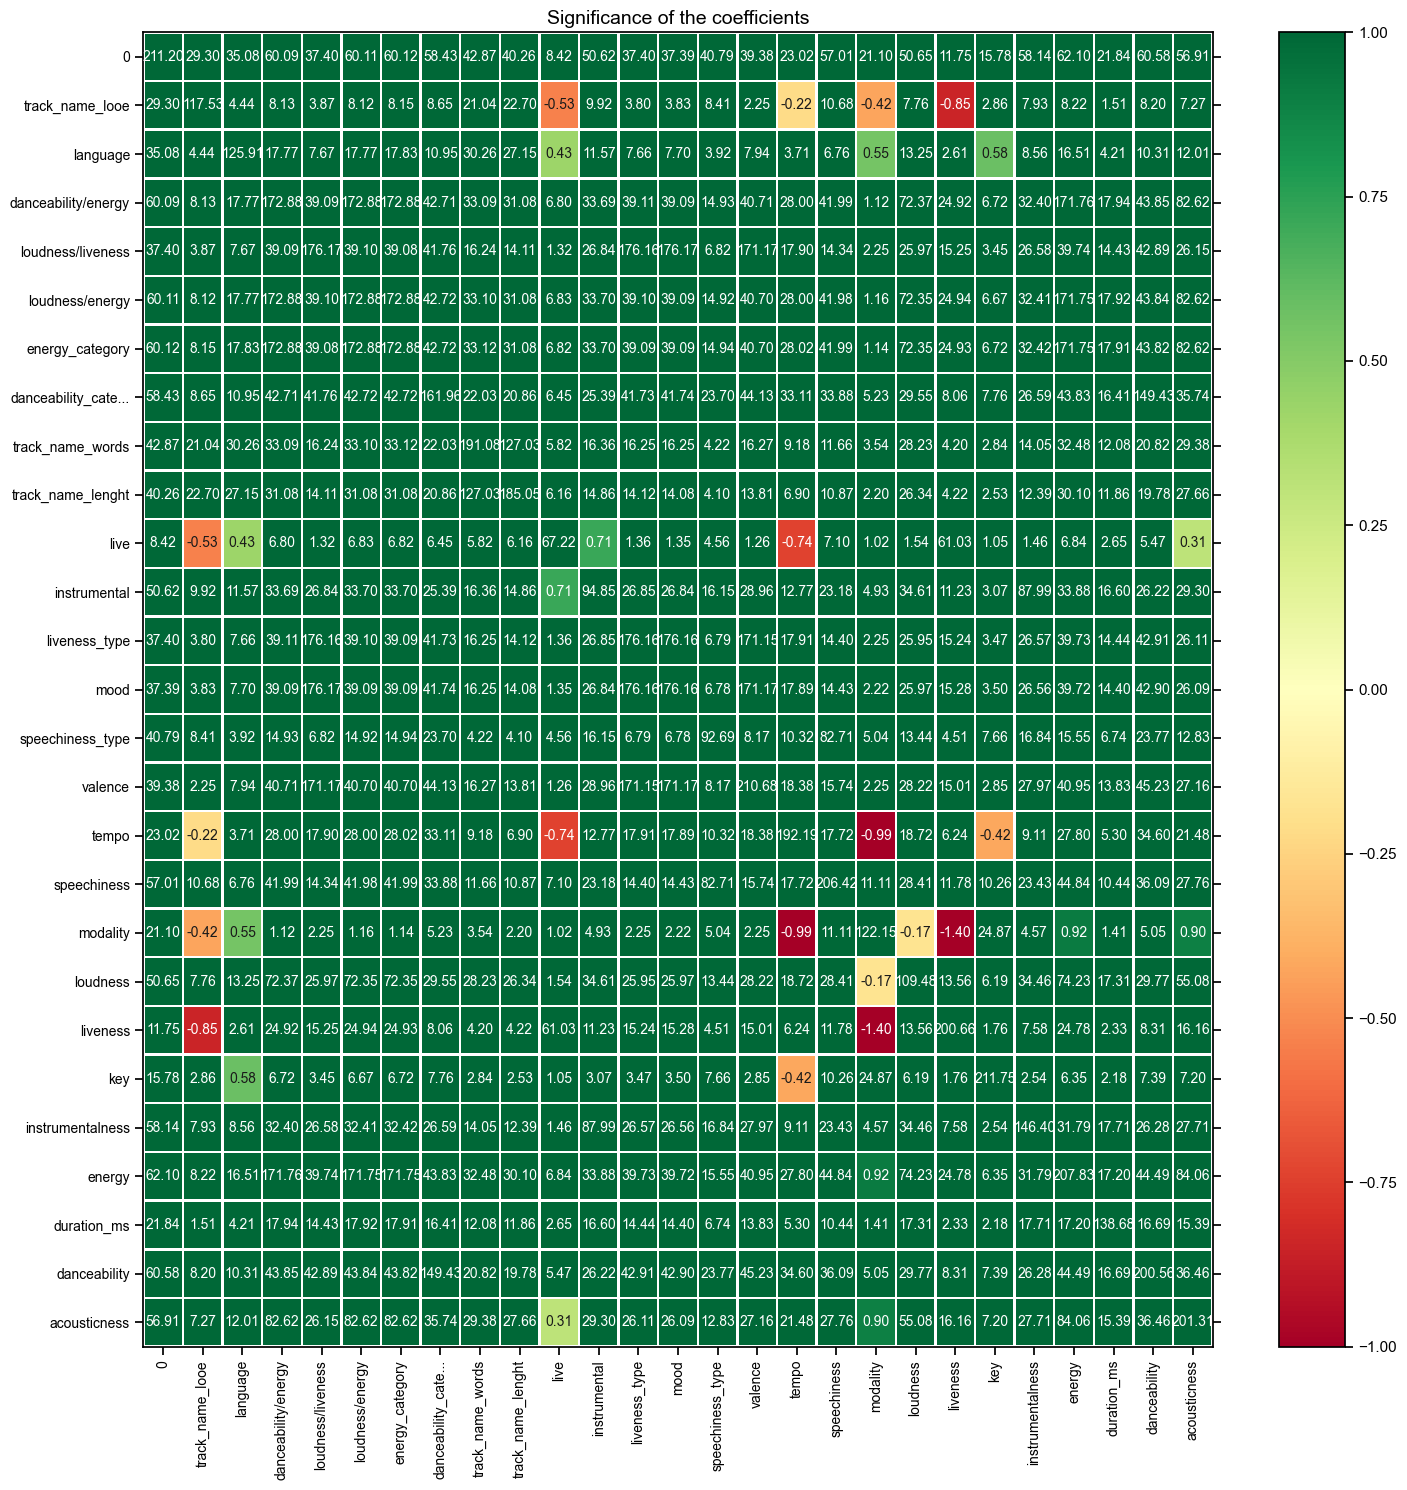

In [43]:
phik_help(pd.concat([train[:10000], pd.DataFrame(target[:10000])], axis=1))

# Построение модели

Для экономии напишем функцию, которая будет выводить основную онформцию об обученной моделе

In [61]:
def make_classification_plots(model_preds, y_test, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    cm_matrix = confusion_matrix(y_test, model_preds)

    # 1 - Summary Statistics
    accuracy = accuracy_score(y_test, model_preds) # % positive out of all predicted positives
    balanced_accuracy = balanced_accuracy_score(y_test, model_preds)
    precision = precision_score(y_test, model_preds, average='weighted') # % positive out of all predicted positives
    recall =  recall_score(y_test, model_preds, average='weighted') # % positive out of all supposed to be positives
    f1 = f1_score(y_test, model_preds, average='weighted')
    fbeta = fbeta_score(y_test, model_preds, beta = 0.5, average = 'weighted')
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Balanced Accuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | F1-Score = {:.2%} | fbeta = {:.2%}'.format(accuracy, balanced_accuracy , precision, recall, f1, fbeta)
    print(stats_summary)

    # 2 : Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, model_preds, ax=axes[0])
    axes[0].set_title("Confusion Matrix")

    # 3 : Normalized Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, model_preds, ax=axes[1], normalize="true", values_format=".0%")
    axes[1].set_title("Normalized Confusion Matrix")

    fig.suptitle(f"{title} Test Metrics", fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 4 : Classification Report
    class_report = classification_report(y_test, model_preds)
    print('\n', f"{title} Classification Report: \n {class_report}")

    plt.style.use('ggplot')

## CatBoostClassifier

Для начала попробуем построить обучную многоклассовую модель

### Многоклассавая

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train, target, 
                                                    test_size=0.2, random_state=42, shuffle=True)

In [63]:
train_pool = Pool(X_train, y_train) # cat_features=[0,2,5])
test_pool = Pool(X_test)

In [66]:
params = {
        'auto_class_weights': 'Balanced',
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3000,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'classes_count': 10,
        'verbose': 100,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Micro',
        'use_best_model': True
    }
    
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(X_test,  y_test), plot=True)#, eval_set=(X_test,  y_test)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3184524	test: 0.3202473	best: 0.3202473 (0)	total: 107ms	remaining: 5m 21s
100:	learn: 0.4392408	test: 0.4305415	best: 0.4316772 (95)	total: 11.3s	remaining: 5m 25s
200:	learn: 0.4589593	test: 0.4401249	best: 0.4438486 (152)	total: 22.5s	remaining: 5m 13s
300:	learn: 0.4770083	test: 0.4604454	best: 0.4604454 (300)	total: 33.7s	remaining: 5m 1s
400:	learn: 0.4962044	test: 0.4729882	best: 0.4729882 (400)	total: 45s	remaining: 4m 51s
500:	learn: 0.5093192	test: 0.4765555	best: 0.4777609 (479)	total: 56.6s	remaining: 4m 42s
600:	learn: 0.5156745	test: 0.4837043	best: 0.4856958 (588)	total: 1m 7s	remaining: 4m 31s
700:	learn: 0.5205213	test: 0.4821544	best: 0.4856958 (588)	total: 1m 19s	remaining: 4m 19s
800:	learn: 0.5268466	test: 0.4810401	best: 0.4856958 (588)	total: 1m 30s	remaining: 4m 8s
900:	learn: 0.5315808	test: 0.4864441	best: 0.4864441 (894)	total: 1m 41s	remaining: 3m 56s
1000:	learn: 0.5364982	test: 0.4859727	best: 0.4871919 (997)	total: 1m 52s	remaining: 3m 45s
110

Text(0.5, 1.0, 'CatBoost Feature Importance')

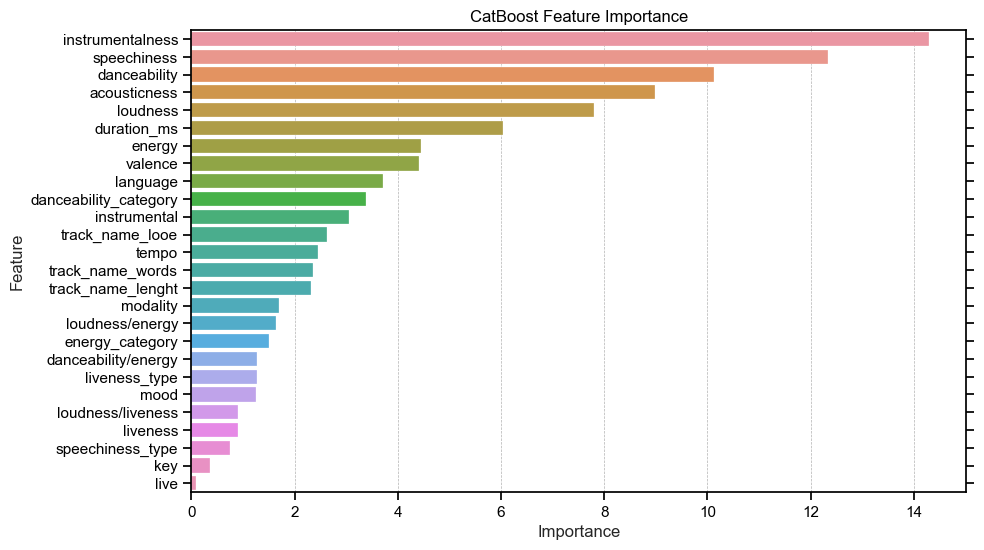

In [67]:
results = list(zip(X_train, clf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
se.barplot(x = importance.Importance, y = importance.Feature)
plt.title("CatBoost Feature Importance")

[Summary Statistics]
Accuracy = 49.17% | Balanced Accuracy = 51.31% | Precision = 48.40% | Recall = 49.17% | F1-Score = 48.18% | fbeta = 48.15%


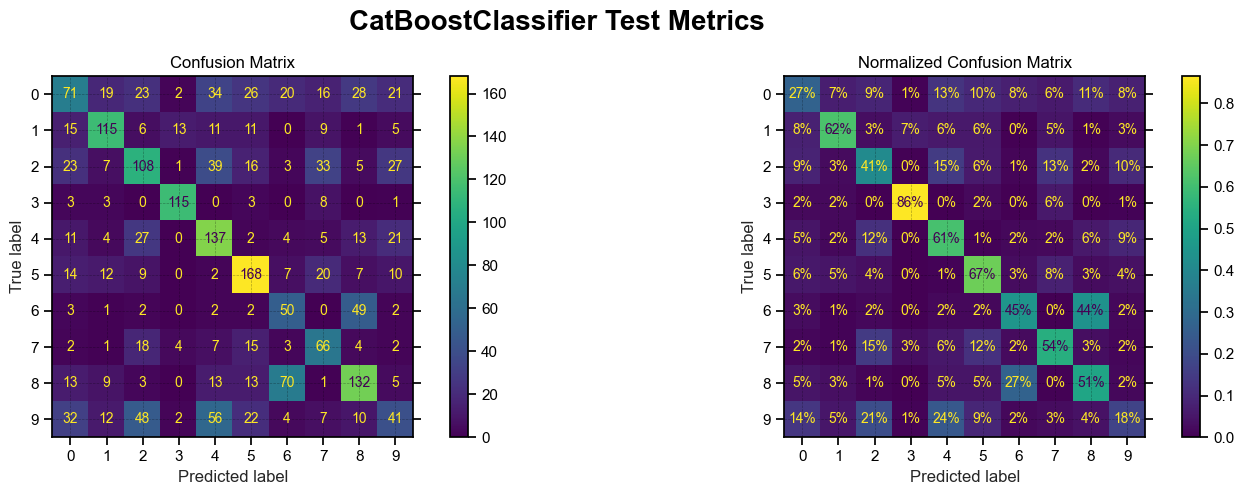


 CatBoostClassifier Classification Report: 
               precision    recall  f1-score   support

           0       0.38      0.27      0.32       260
           1       0.63      0.62      0.62       186
           2       0.44      0.41      0.43       262
           3       0.84      0.86      0.85       133
           4       0.46      0.61      0.52       224
           5       0.60      0.67      0.64       249
           6       0.31      0.45      0.37       111
           7       0.40      0.54      0.46       122
           8       0.53      0.51      0.52       259
           9       0.30      0.18      0.22       234

    accuracy                           0.49      2040
   macro avg       0.49      0.51      0.49      2040
weighted avg       0.48      0.49      0.48      2040



In [68]:
make_classification_plots(clf.predict(X_test), y_test, 'CatBoostClassifier')

### Ансамбль, один против всех

In [325]:
target_str = labelencoder.inverse_transform(target)
target_ohe = pd.get_dummies(target_str)

Так как у нас двуэтапная модель, то данные сперва разбиваются на 2 части. 

In [326]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(train, target_ohe, 
                                                    test_size=0.5, random_state=42, shuffle=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7390862	test: 0.7456329	best: 0.7456329 (0)	total: 36.3ms	remaining: 2m 7s
200:	learn: 0.8842568	test: 0.8868937	best: 0.8868937 (196)	total: 4.82s	remaining: 1m 19s
400:	learn: 0.8977783	test: 0.8941189	best: 0.8947823 (287)	total: 9.63s	remaining: 1m 14s
600:	learn: 0.9042572	test: 0.8957935	best: 0.8969599 (575)	total: 14.4s	remaining: 1m 9s
800:	learn: 0.9113514	test: 0.8963461	best: 0.8980813 (684)	total: 19.1s	remaining: 1m 4s
1000:	learn: 0.9164590	test: 0.8986025	best: 0.8986184 (882)	total: 23.9s	remaining: 59.7s
1200:	learn: 0.9214969	test: 0.9003069	best: 0.9014753 (1069)	total: 28.8s	remaining: 55.1s
1400:	learn: 0.9254605	test: 0.9014594	best: 0.9020115 (1328)	total: 33.6s	remaining: 50.3s
1600:	learn: 0.9271058	test: 0.9014753	best: 0.9020436 (1447)	total: 37.9s	remaining: 45s
1800:	learn: 0.9281124	test: 0.9020592	best: 0.9020592 (1779)	total: 42s	remaining: 39.6s
2000:	learn: 0.9291209	test: 0.9003229	best: 0.9020592 (1779)	total: 45.4s	remaining: 34s
2200:	

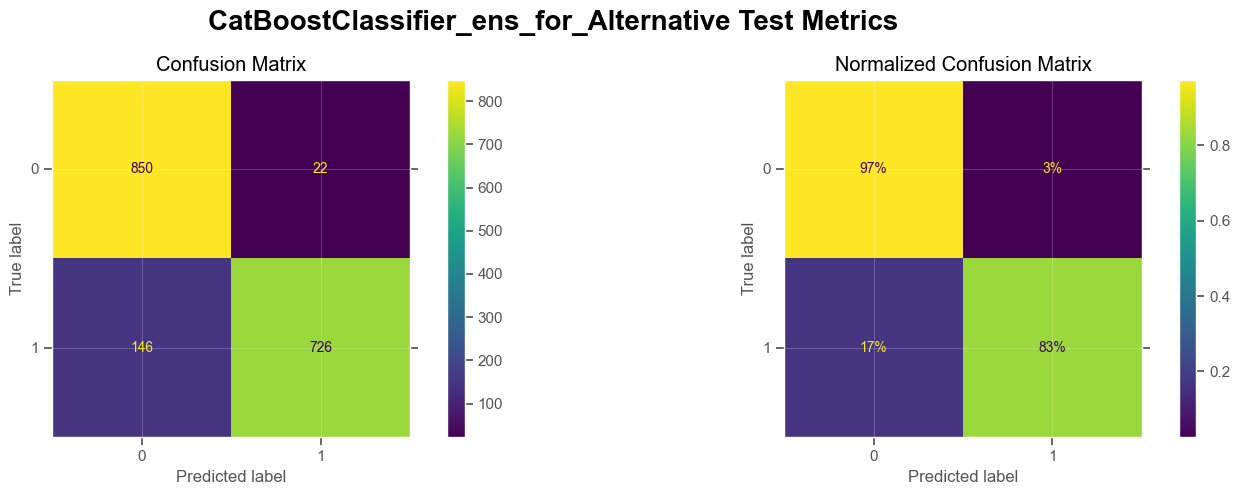


 CatBoostClassifier_ens_for_Alternative Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       872
           1       0.97      0.83      0.90       872

    accuracy                           0.90      1744
   macro avg       0.91      0.90      0.90      1744
weighted avg       0.91      0.90      0.90      1744



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7657841	test: 0.7884969	best: 0.7884969 (0)	total: 23.7ms	remaining: 1m 22s
200:	learn: 0.9149522	test: 0.9234025	best: 0.9239318 (197)	total: 4.52s	remaining: 1m 14s
400:	learn: 0.9383379	test: 0.9495177	best: 0.9495177 (399)	total: 8.99s	remaining: 1m 9s
600:	learn: 0.9500665	test: 0.9553666	best: 0.9564293 (550)	total: 13.5s	remaining: 1m 5s
800:	learn: 0.9564429	test: 0.9553654	best: 0.9574916 (710)	total: 18s	remaining: 1m
1000:	learn: 0.9603540	test: 0.9585524	best: 0.9585524 (997)	total: 22.6s	remaining: 56.4s
1200:	learn: 0.9651071	test: 0.9601462	best: 0.9601462 (1185)	total: 27.4s	remaining: 52.4s
1400:	learn: 0.9676342	test: 0.9622724	best: 0.9628040 (1343)	total: 31.9s	remaining: 47.8s
1600:	learn: 0.9702214	test: 0.9628028	best: 0.9633345 (1449)	total: 36.5s	remaining: 43.4s
1800:	learn: 0.9712443	test: 0.9606765	best: 0.9633345 (1449)	total: 40.7s	remaining: 38.4s
2000:	learn: 0.9719665	test: 0.9617393	best: 0.9633345 (1449)	total: 44.1s	remaining: 33.1s
2200:

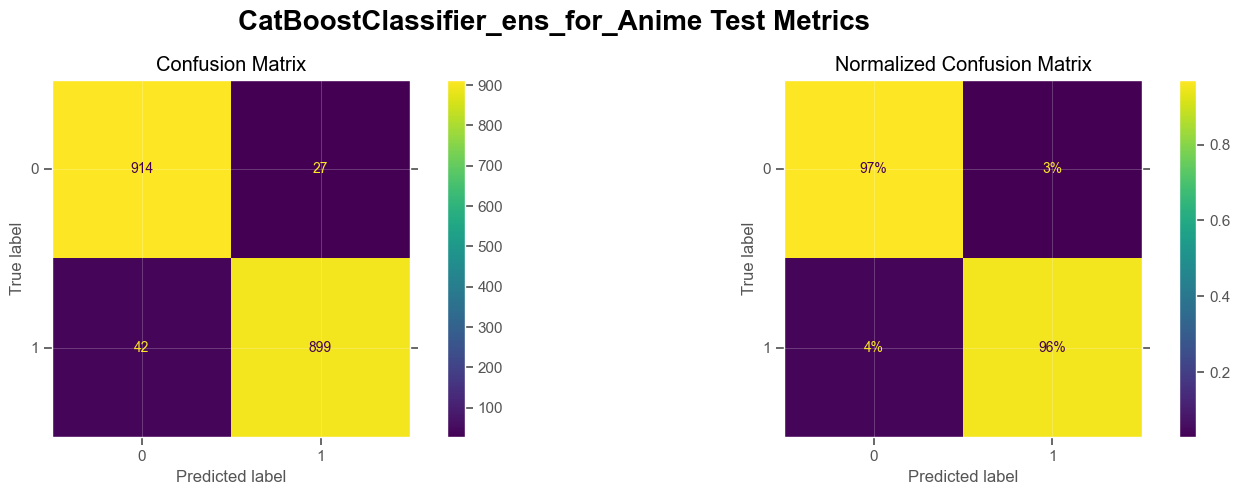


 CatBoostClassifier_ens_for_Anime Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       941
           1       0.97      0.96      0.96       941

    accuracy                           0.96      1882
   macro avg       0.96      0.96      0.96      1882
weighted avg       0.96      0.96      0.96      1882



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7966887	test: 0.7848044	best: 0.7848044 (0)	total: 24.8ms	remaining: 1m 26s
200:	learn: 0.8850862	test: 0.8844357	best: 0.8844357 (195)	total: 4.71s	remaining: 1m 17s
400:	learn: 0.9060972	test: 0.9019121	best: 0.9024778 (370)	total: 9.42s	remaining: 1m 12s
600:	learn: 0.9143262	test: 0.9086693	best: 0.9098027 (509)	total: 14.2s	remaining: 1m 8s
800:	learn: 0.9179978	test: 0.9080927	best: 0.9098027 (509)	total: 18.9s	remaining: 1m 3s
1000:	learn: 0.9227502	test: 0.9103371	best: 0.9109030 (997)	total: 23.5s	remaining: 58.7s
1200:	learn: 0.9287025	test: 0.9136884	best: 0.9142743 (1085)	total: 28.3s	remaining: 54.3s
1400:	learn: 0.9312364	test: 0.9142498	best: 0.9148218 (1333)	total: 33.1s	remaining: 49.5s
1600:	learn: 0.9345327	test: 0.9165116	best: 0.9165116 (1590)	total: 37.8s	remaining: 44.8s
1800:	learn: 0.9366896	test: 0.9176398	best: 0.9176398 (1675)	total: 42.6s	remaining: 40.2s
2000:	learn: 0.9394812	test: 0.9170782	best: 0.9182014 (1811)	total: 47.4s	remaining: 35.5s

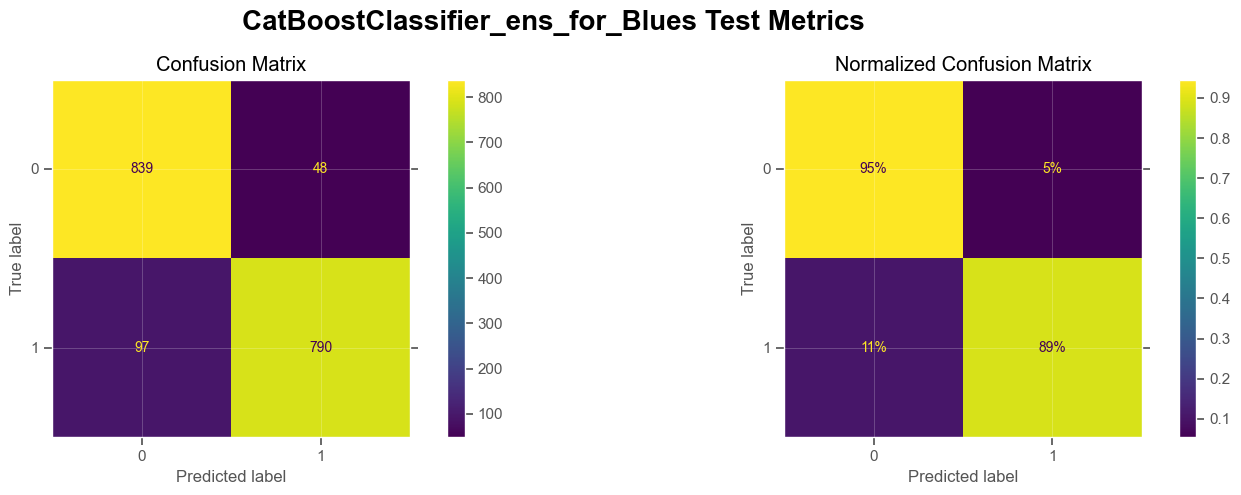


 CatBoostClassifier_ens_for_Blues Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       887
           1       0.94      0.89      0.92       887

    accuracy                           0.92      1774
   macro avg       0.92      0.92      0.92      1774
weighted avg       0.92      0.92      0.92      1774



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9559978	test: 0.9420369	best: 0.9420369 (0)	total: 23.5ms	remaining: 1m 22s
200:	learn: 0.9796681	test: 0.9750264	best: 0.9750264 (199)	total: 4.45s	remaining: 1m 12s
400:	learn: 0.9851601	test: 0.9814028	best: 0.9819341 (368)	total: 8.82s	remaining: 1m 8s
600:	learn: 0.9874386	test: 0.9824655	best: 0.9824655 (469)	total: 13.3s	remaining: 1m 3s
800:	learn: 0.9886072	test: 0.9840595	best: 0.9840595 (771)	total: 17.6s	remaining: 59.4s
1000:	learn: 0.9894251	test: 0.9845908	best: 0.9851222 (950)	total: 22s	remaining: 55s
1200:	learn: 0.9901846	test: 0.9851222	best: 0.9851222 (950)	total: 26.5s	remaining: 50.7s
1400:	learn: 0.9906520	test: 0.9856535	best: 0.9856535 (1256)	total: 31s	remaining: 46.5s
1600:	learn: 0.9915868	test: 0.9851222	best: 0.9856535 (1256)	total: 35.9s	remaining: 42.6s
1800:	learn: 0.9923463	test: 0.9861849	best: 0.9861849 (1631)	total: 40.4s	remaining: 38.1s
2000:	learn: 0.9930474	test: 0.9861849	best: 0.9861849 (1631)	total: 44.9s	remaining: 33.7s
2200:	l

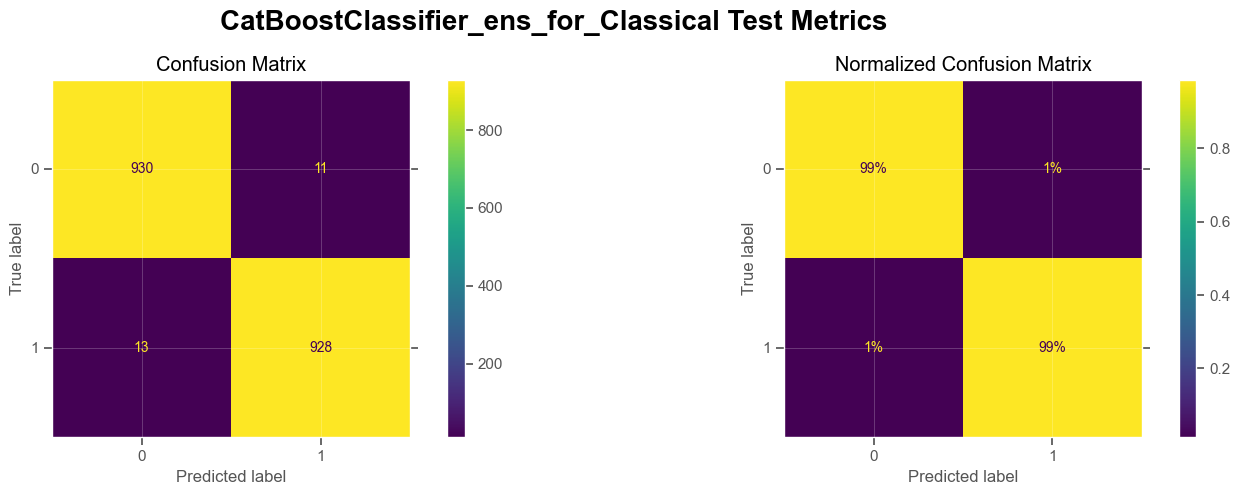


 CatBoostClassifier_ens_for_Classical Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       941
           1       0.99      0.99      0.99       941

    accuracy                           0.99      1882
   macro avg       0.99      0.99      0.99      1882
weighted avg       0.99      0.99      0.99      1882



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8187618	test: 0.8392808	best: 0.8392808 (0)	total: 39.5ms	remaining: 2m 18s
200:	learn: 0.9022162	test: 0.9215144	best: 0.9215144 (199)	total: 4.46s	remaining: 1m 13s
400:	learn: 0.9269104	test: 0.9323882	best: 0.9323882 (381)	total: 8.79s	remaining: 1m 7s
600:	learn: 0.9369374	test: 0.9404498	best: 0.9404498 (558)	total: 13.1s	remaining: 1m 3s
800:	learn: 0.9412481	test: 0.9415232	best: 0.9420600 (702)	total: 17.6s	remaining: 59.2s
1000:	learn: 0.9455595	test: 0.9436687	best: 0.9436687 (951)	total: 22s	remaining: 54.8s
1200:	learn: 0.9506604	test: 0.9452749	best: 0.9479588 (1082)	total: 26.4s	remaining: 50.5s
1400:	learn: 0.9538793	test: 0.9474188	best: 0.9479588 (1082)	total: 30.8s	remaining: 46.2s
1600:	learn: 0.9563077	test: 0.9468789	best: 0.9479588 (1082)	total: 35.3s	remaining: 41.9s
1800:	learn: 0.9591029	test: 0.9447325	best: 0.9479588 (1082)	total: 39.7s	remaining: 37.5s
2000:	learn: 0.9602574	test: 0.9458023	best: 0.9479588 (1082)	total: 44s	remaining: 33s
2200:	

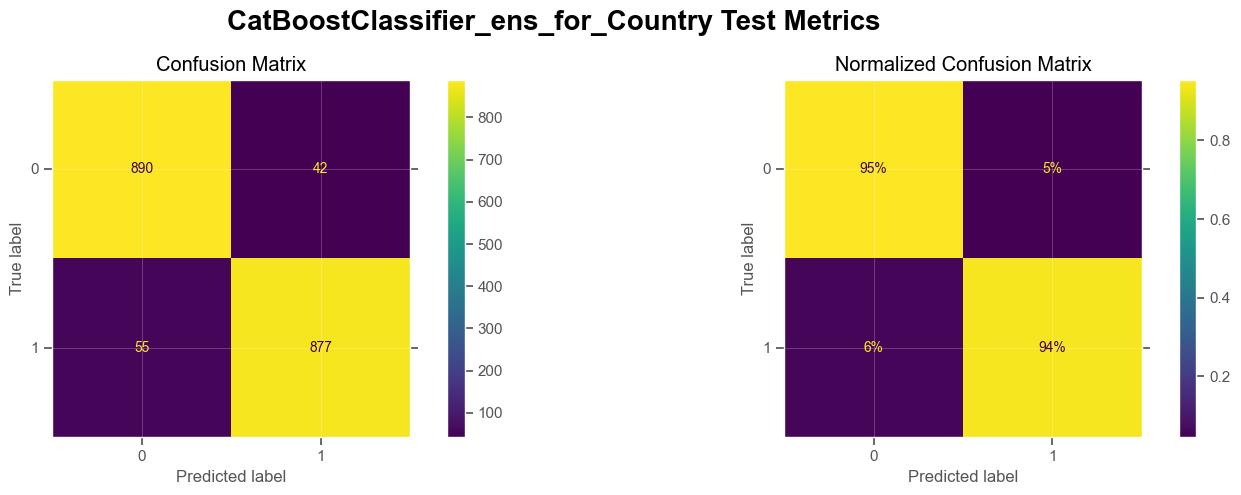


 CatBoostClassifier_ens_for_Country Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       932
           1       0.95      0.94      0.95       932

    accuracy                           0.95      1864
   macro avg       0.95      0.95      0.95      1864
weighted avg       0.95      0.95      0.95      1864



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8587911	test: 0.8467553	best: 0.8467553 (0)	total: 25.3ms	remaining: 1m 28s
200:	learn: 0.9139894	test: 0.9090214	best: 0.9090214 (194)	total: 4.62s	remaining: 1m 15s
400:	learn: 0.9317135	test: 0.9231637	best: 0.9231638 (381)	total: 9.26s	remaining: 1m 11s
600:	learn: 0.9380508	test: 0.9271119	best: 0.9271119 (575)	total: 13.8s	remaining: 1m 6s
800:	learn: 0.9440767	test: 0.9310608	best: 0.9321929 (765)	total: 18.3s	remaining: 1m 1s
1000:	learn: 0.9485495	test: 0.9333211	best: 0.9333211 (978)	total: 22.9s	remaining: 57.3s
1200:	learn: 0.9531475	test: 0.9355793	best: 0.9361455 (1180)	total: 27.9s	remaining: 53.4s
1400:	learn: 0.9563158	test: 0.9361455	best: 0.9361455 (1180)	total: 32.3s	remaining: 48.4s
1600:	learn: 0.9581792	test: 0.9367095	best: 0.9367095 (1418)	total: 36.5s	remaining: 43.3s
1800:	learn: 0.9609132	test: 0.9384015	best: 0.9384015 (1791)	total: 41.2s	remaining: 38.9s
2000:	learn: 0.9625912	test: 0.9378376	best: 0.9395318 (1872)	total: 45.4s	remaining: 34s
2

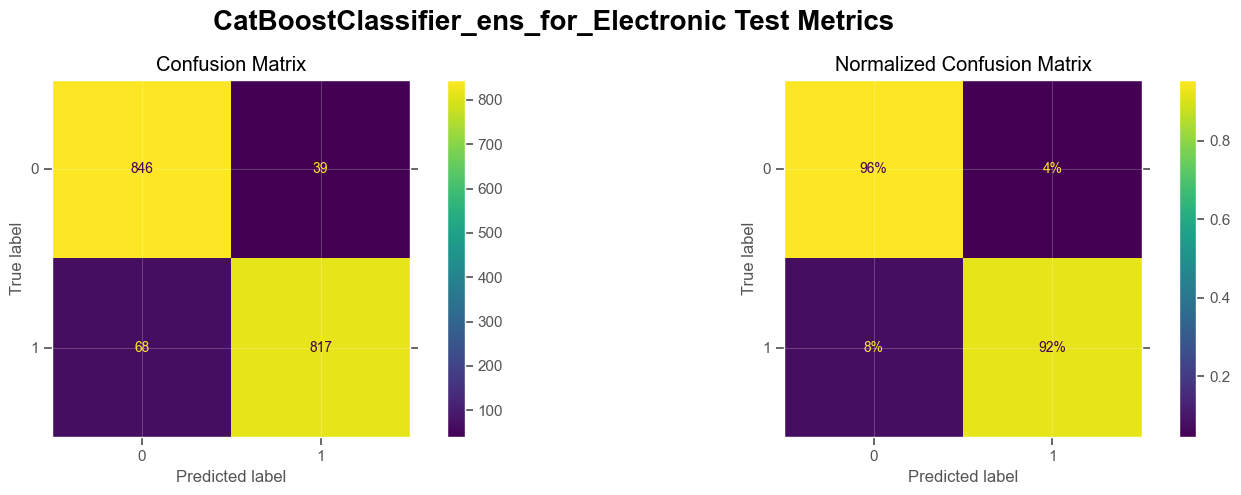


 CatBoostClassifier_ens_for_Electronic Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       885
           1       0.95      0.92      0.94       885

    accuracy                           0.94      1770
   macro avg       0.94      0.94      0.94      1770
weighted avg       0.94      0.94      0.94      1770



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8563435	test: 0.8596491	best: 0.8596491 (0)	total: 22.9ms	remaining: 1m 20s
200:	learn: 0.9262558	test: 0.9358961	best: 0.9358961 (200)	total: 4.52s	remaining: 1m 14s
400:	learn: 0.9461012	test: 0.9535461	best: 0.9535461 (395)	total: 8.97s	remaining: 1m 9s
600:	learn: 0.9566496	test: 0.9582025	best: 0.9587187 (590)	total: 13.1s	remaining: 1m 3s
800:	learn: 0.9645210	test: 0.9582043	best: 0.9587203 (777)	total: 17.4s	remaining: 58.6s
1000:	learn: 0.9694396	test: 0.9613001	best: 0.9613001 (989)	total: 21.9s	remaining: 54.6s
1200:	learn: 0.9730274	test: 0.9649109	best: 0.9649109 (1200)	total: 26.4s	remaining: 50.4s
1400:	learn: 0.9754583	test: 0.9638778	best: 0.9649109 (1200)	total: 30.9s	remaining: 46.3s
1600:	learn: 0.9763841	test: 0.9628451	best: 0.9649109 (1200)	total: 34.6s	remaining: 41s
1800:	learn: 0.9781784	test: 0.9633621	best: 0.9649109 (1200)	total: 38.9s	remaining: 36.7s
2000:	learn: 0.9786413	test: 0.9643942	best: 0.9649109 (1200)	total: 42.9s	remaining: 32.2s
22

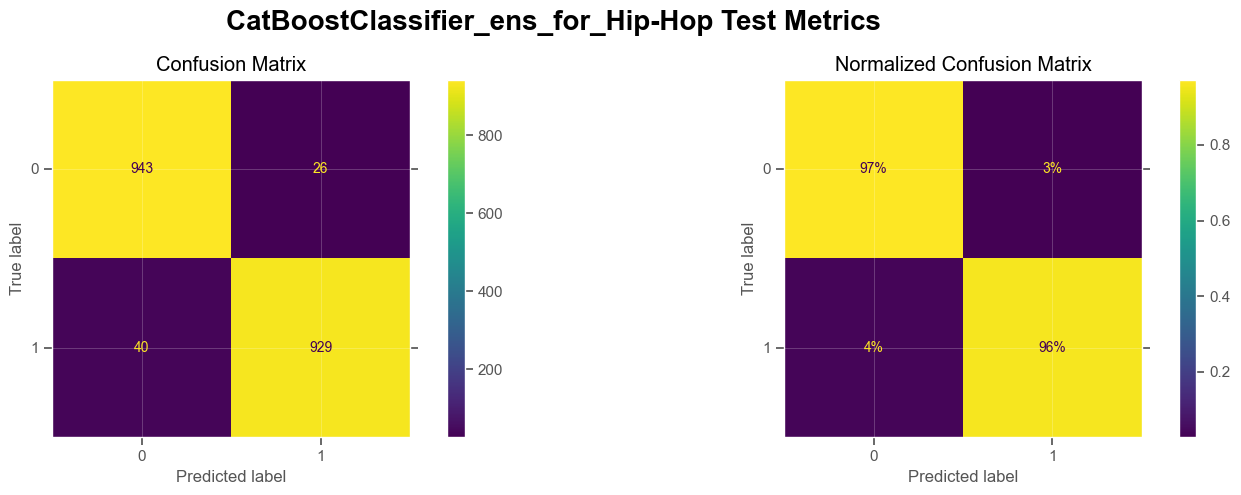


 CatBoostClassifier_ens_for_Hip-Hop Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       969
           1       0.97      0.96      0.97       969

    accuracy                           0.97      1938
   macro avg       0.97      0.97      0.97      1938
weighted avg       0.97      0.97      0.97      1938



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8127275	test: 0.8499418	best: 0.8499418 (0)	total: 26.1ms	remaining: 1m 31s
200:	learn: 0.9233341	test: 0.9325816	best: 0.9325816 (200)	total: 4.22s	remaining: 1m 9s
400:	learn: 0.9453012	test: 0.9497361	best: 0.9497361 (389)	total: 8.47s	remaining: 1m 5s
600:	learn: 0.9567537	test: 0.9544024	best: 0.9549208 (568)	total: 12.7s	remaining: 1m 1s
800:	learn: 0.9633775	test: 0.9585428	best: 0.9585428 (771)	total: 16.9s	remaining: 57s
1000:	learn: 0.9680844	test: 0.9611299	best: 0.9616475 (961)	total: 21.1s	remaining: 52.7s
1200:	learn: 0.9716298	test: 0.9626813	best: 0.9631989 (1187)	total: 25.4s	remaining: 48.6s
1400:	learn: 0.9738387	test: 0.9600873	best: 0.9631989 (1187)	total: 29.5s	remaining: 44.3s
1600:	learn: 0.9750597	test: 0.9569714	best: 0.9631989 (1187)	total: 33.1s	remaining: 39.3s
1800:	learn: 0.9755248	test: 0.9574909	best: 0.9631989 (1187)	total: 36.2s	remaining: 34.2s
2000:	learn: 0.9760479	test: 0.9569671	best: 0.9631989 (1187)	total: 39.4s	remaining: 29.5s
220

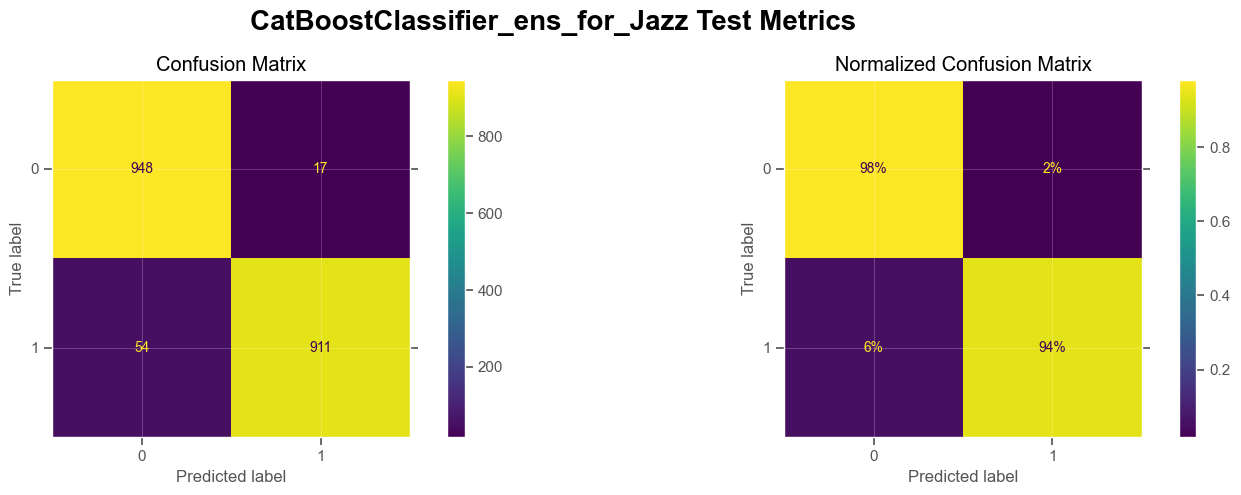


 CatBoostClassifier_ens_for_Jazz Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       965
           1       0.98      0.94      0.96       965

    accuracy                           0.96      1930
   macro avg       0.96      0.96      0.96      1930
weighted avg       0.96      0.96      0.96      1930



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8466780	test: 0.8390505	best: 0.8390505 (0)	total: 25ms	remaining: 1m 27s
200:	learn: 0.9116281	test: 0.9153119	best: 0.9158667 (196)	total: 4.36s	remaining: 1m 11s
400:	learn: 0.9278227	test: 0.9264975	best: 0.9264975 (395)	total: 8.63s	remaining: 1m 6s
600:	learn: 0.9358050	test: 0.9298440	best: 0.9298440 (588)	total: 12.9s	remaining: 1m 2s
800:	learn: 0.9410016	test: 0.9309569	best: 0.9315145 (660)	total: 17.3s	remaining: 58.3s
1000:	learn: 0.9450216	test: 0.9331819	best: 0.9337392 (953)	total: 21.6s	remaining: 54s
1200:	learn: 0.9480519	test: 0.9326205	best: 0.9337392 (953)	total: 25.8s	remaining: 49.5s
1400:	learn: 0.9518243	test: 0.9326189	best: 0.9337392 (953)	total: 30.3s	remaining: 45.4s
1600:	learn: 0.9533703	test: 0.9348463	best: 0.9348463 (1506)	total: 34.9s	remaining: 41.4s
1800:	learn: 0.9554729	test: 0.9365192	best: 0.9365192 (1786)	total: 39.5s	remaining: 37.3s
2000:	learn: 0.9572046	test: 0.9376342	best: 0.9381905 (1913)	total: 44.1s	remaining: 33s
2200:	le

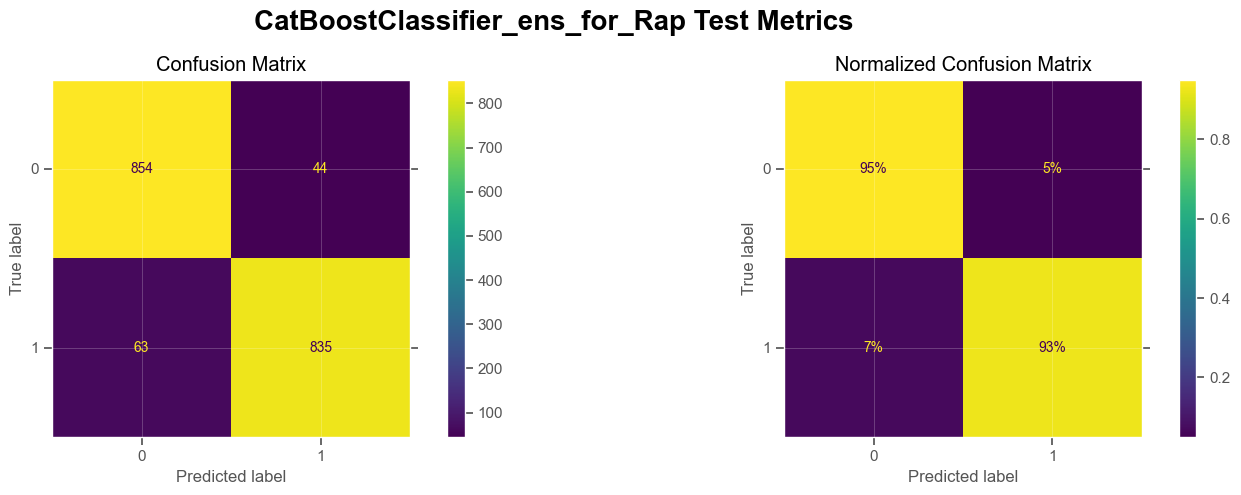


 CatBoostClassifier_ens_for_Rap Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       898
           1       0.95      0.93      0.94       898

    accuracy                           0.94      1796
   macro avg       0.94      0.94      0.94      1796
weighted avg       0.94      0.94      0.94      1796



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7489283	test: 0.7512800	best: 0.7512800 (0)	total: 20.6ms	remaining: 1m 12s
200:	learn: 0.8872489	test: 0.8803135	best: 0.8803135 (200)	total: 4.03s	remaining: 1m 6s
400:	learn: 0.9119586	test: 0.8992397	best: 0.8992397 (386)	total: 8.03s	remaining: 1m 2s
600:	learn: 0.9202849	test: 0.9059003	best: 0.9059003 (594)	total: 12s	remaining: 58s
800:	learn: 0.9276242	test: 0.9109319	best: 0.9109319 (798)	total: 16s	remaining: 54s
1000:	learn: 0.9326683	test: 0.9120236	best: 0.9126173 (834)	total: 20.1s	remaining: 50.1s
1200:	learn: 0.9376959	test: 0.9119986	best: 0.9126173 (834)	total: 24.4s	remaining: 46.8s
1400:	learn: 0.9407365	test: 0.9136590	best: 0.9136720 (1329)	total: 28.4s	remaining: 42.6s
1600:	learn: 0.9435981	test: 0.9136590	best: 0.9142298 (1480)	total: 32.3s	remaining: 38.3s
1800:	learn: 0.9464043	test: 0.9125171	best: 0.9142298 (1480)	total: 36.5s	remaining: 34.4s
2000:	learn: 0.9481102	test: 0.9130881	best: 0.9142298 (1480)	total: 40.6s	remaining: 30.4s
2200:	lear

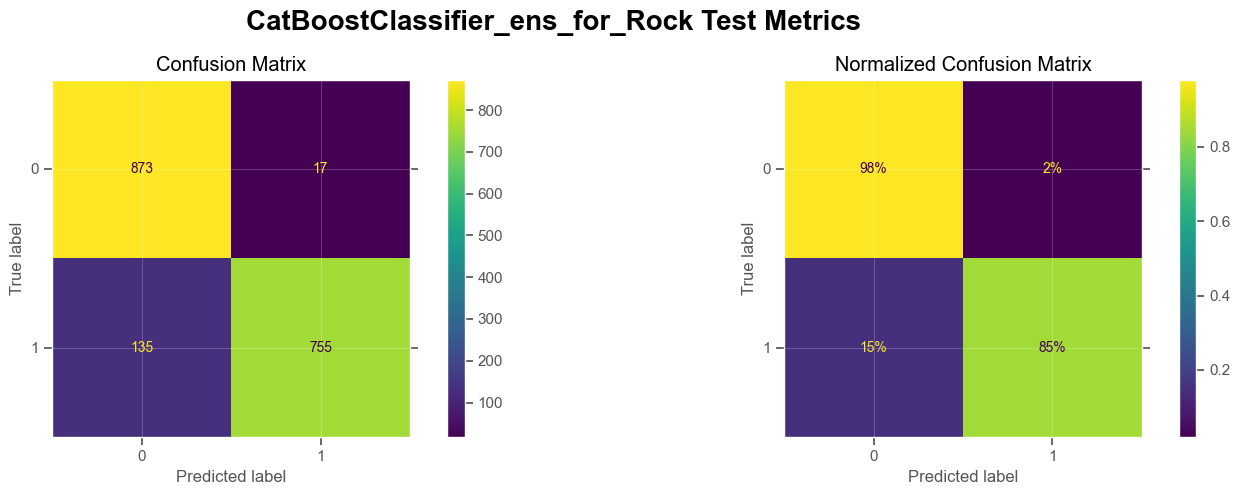


 CatBoostClassifier_ens_for_Rock Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       890
           1       0.98      0.85      0.91       890

    accuracy                           0.91      1780
   macro avg       0.92      0.91      0.91      1780
weighted avg       0.92      0.91      0.91      1780



In [329]:
model_dict = {}
for i in target_ohe.columns:
    X_train, X_test, y_train, y_test = train_test_split(X_train1.drop(columns='track_name'), y_train1[i], 
                                                    test_size=0.1, random_state=42, shuffle=True)
    
    X_train, y_train = BorderlineSMOTE().fit_resample(X_train, y_train)
    
    X_test, y_test = BorderlineSMOTE().fit_resample(X_test, y_test)
    #X_train, y_train = use_upscaling(X_train, pd.DataFrame(y_train))
    
    train_pool = Pool(X_train, y_train) #, cat_features=['key', 'mode', 'kmean',  'Birch']
    
    
    params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3500,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 2.0,
        'random_state': 42,
        'verbose': 200,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }
    
    clf = CatBoostClassifier(**params)
    clf.fit(train_pool, eval_set=(X_test, y_test), plot=True)
    
    make_classification_plots(clf.predict(X_test), y_test, f'CatBoostClassifier_ens_for_{i}')
    
    model_dict[i] = clf
    
    

In [356]:
y_train11 =  pd.DataFrame(y_train1.idxmax(axis=1))
y_train11.columns = ['music_genre']

In [357]:
Tfidf_NB_col = Tfidf_NB(X_train1, y_train11, X_train2)

In [358]:
X_train2 = pd.concat([X_train2.reset_index(drop=True), Tfidf_NB_col], axis=1)

In [359]:
def classes_predict(data, target, model_dict, pref='cat'):
    ans_model = []
    for i in target.columns:
        pred = model_dict[i].predict_proba(data)[:, 1].T
        ans_model.append(pred)
    ans_model = np.array(ans_model) 
    ans_model = pd.DataFrame(ans_model.T, columns=[f'{col}_{pref}' for col in target.columns])
    return pd.concat([data.reset_index(drop=True), ans_model], axis=1)

In [360]:
X_train, X_test, y_train, y_test = train_test_split(X_train2 , y_train2, 
                                                    test_size=0.1, random_state=42, shuffle=True)

In [374]:
train_ens_catboost = classes_predict(X_train.drop(columns=['Tfidf_NB', 'track_name']) , y_train, model_dict)
test_ens_catboost = classes_predict(X_test.drop(columns=['Tfidf_NB', 'track_name']), y_test, model_dict)

In [375]:
train_ens_catboost = pd.concat([train_ens_catboost, X_train['Tfidf_NB'].reset_index(drop=True)], axis=1)
test_ens_catboost = pd.concat([test_ens_catboost, X_test['Tfidf_NB'].reset_index(drop=True)], axis=1)

In [380]:
labelencoder = LabelEncoder()
train_ens_catboost['Tfidf_NB'] = labelencoder.fit_transform(train_ens_catboost['Tfidf_NB'])
test_ens_catboost['Tfidf_NB'] = labelencoder.transform(test_ens_catboost['Tfidf_NB'])

In [382]:
target_train = y_train.idxmax(axis=1)
target_test = y_test.idxmax(axis=1)

In [383]:
labelencoder = LabelEncoder()
target_train = labelencoder.fit_transform(target_train)
target_test = labelencoder.transform(target_test)

In [384]:
train_pool = Pool(train_ens_catboost, target_train) #, cat_features=['key', 'mode', 'kmean']

In [385]:
params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3000,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'verbose': 200,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }

train_pool = Pool(train_ens_catboost, target_train)
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(test_ens_catboost,  target_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3551041	test: 0.3629495	best: 0.3629495 (0)	total: 147ms	remaining: 7m 19s
200:	learn: 0.4527947	test: 0.4654143	best: 0.4654143 (200)	total: 30s	remaining: 6m 57s
400:	learn: 0.4851209	test: 0.4894645	best: 0.4907129 (315)	total: 59.6s	remaining: 6m 26s
600:	learn: 0.4984910	test: 0.4946382	best: 0.4968860 (505)	total: 1m 29s	remaining: 5m 57s
800:	learn: 0.5095787	test: 0.4960674	best: 0.4979169 (791)	total: 1m 59s	remaining: 5m 28s
1000:	learn: 0.5186010	test: 0.4996250	best: 0.5011470 (868)	total: 2m 28s	remaining: 4m 57s
1200:	learn: 0.5243816	test: 0.5031916	best: 0.5032395 (1191)	total: 2m 59s	remaining: 4m 28s
1400:	learn: 0.5362363	test: 0.5023579	best: 0.5032737 (1202)	total: 3m 29s	remaining: 3m 59s
1600:	learn: 0.5457145	test: 0.5038956	best: 0.5057425 (1478)	total: 4m	remaining: 3m 29s
1800:	learn: 0.5517780	test: 0.5033483	best: 0.5080996 (1655)	total: 4m 30s	remaining: 3m
2000:	learn: 0.5603764	test: 0.5066337	best: 0.5080996 (1655)	total: 5m 1s	remaining: 2m

[Summary Statistics]
Accuracy = 54.22% | Balanced Accuracy = 52.54% | Precision = 54.80% | Recall = 54.22% | F1-Score = 52.78% | fbeta = 53.35%


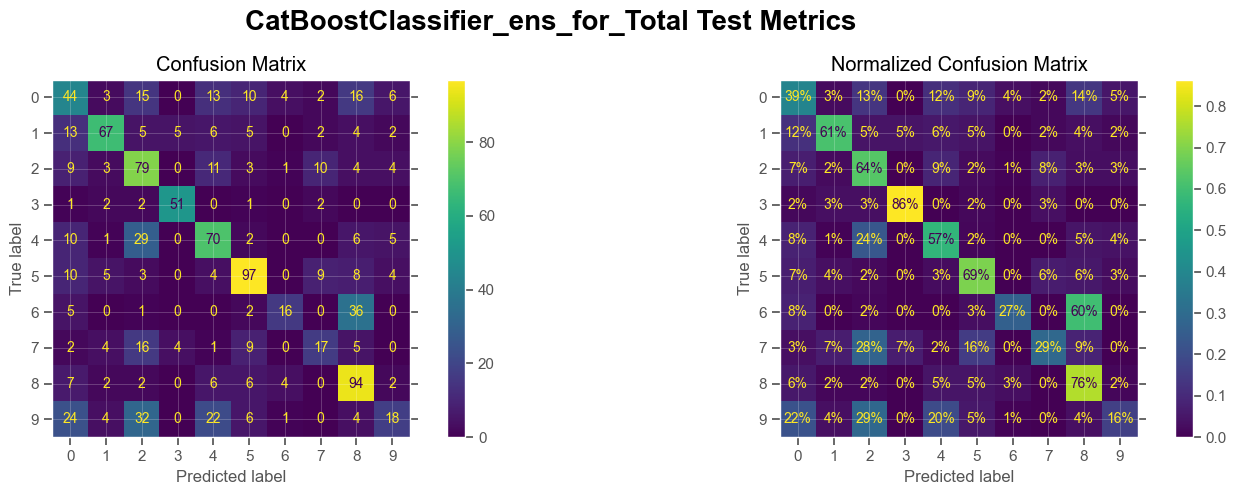


 CatBoostClassifier_ens_for_Total Classification Report: 
               precision    recall  f1-score   support

           0       0.35      0.39      0.37       113
           1       0.74      0.61      0.67       109
           2       0.43      0.64      0.51       124
           3       0.85      0.86      0.86        59
           4       0.53      0.57      0.55       123
           5       0.69      0.69      0.69       140
           6       0.62      0.27      0.37        60
           7       0.40      0.29      0.34        58
           8       0.53      0.76      0.63       123
           9       0.44      0.16      0.24       111

    accuracy                           0.54      1020
   macro avg       0.56      0.53      0.52      1020
weighted avg       0.55      0.54      0.53      1020



In [387]:
make_classification_plots(clf.predict(test_ens_catboost), target_test, f'CatBoostClassifier_ens_for_Total')

['Blues_cat', 'Electronic_cat', 'Rap_cat', 'Country_cat', 'Anime_cat', 'Classical_cat', 'Hip-Hop_cat', 'Jazz_cat', 'Alternative_cat', 'Rock_cat', 'acousticness', 'instrumentalness', 'loudness', 'danceability', 'Tfidf_NB', 'speechiness', 'energy', 'track_name_looe', 'valence', 'duration_ms', 'tempo', 'instrumental', 'track_name_lenght', 'liveness', 'language', 'danceability_category', 'key', 'loudness/energy', 'energy_category', 'danceability/energy', 'track_name_words', 'modality', 'liveness_type', 'mood', 'loudness/liveness', 'speechiness_type']


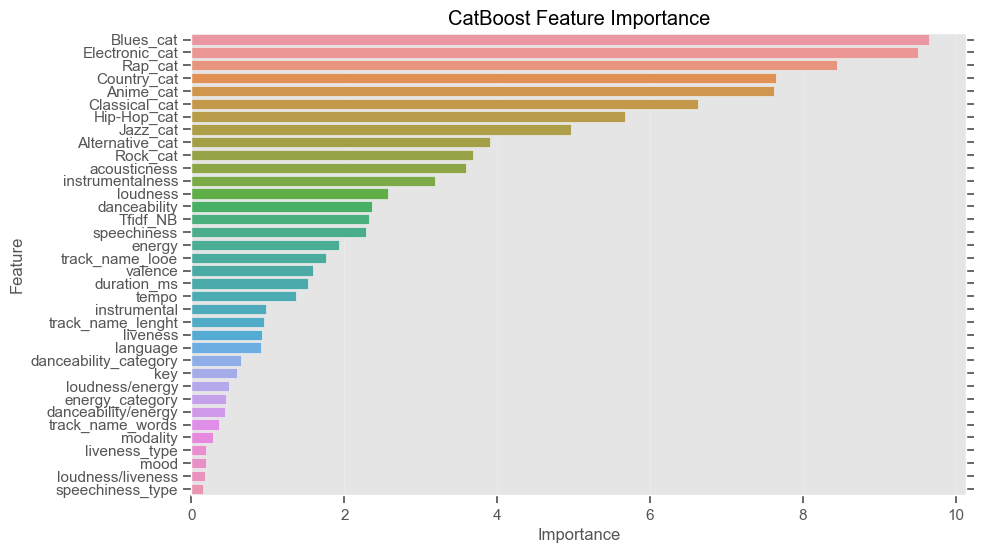

In [389]:
results = list(zip(train_ens_catboost, clf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
se.barplot(x = importance.Importance, y = importance.Feature)
plt.title("CatBoost Feature Importance")

print(importance.Feature.tolist())

#### Create Submition

In [431]:
test1 = test.copy()

In [432]:
index = test1['instance_id']

In [441]:
tt = pd.DataFrame(labelencoder.inverse_transform(target))
tt.columns = ['music_genre']

In [442]:
Tfidf_NB_col_test = Tfidf_NB(train,tt, test1)

In [443]:
test1.drop(columns='track_name', inplace=True)
test1.set_index('instance_id', drop=True, inplace=True)

In [444]:
test1 = classes_predict(test1, y_train, model_dict)

In [445]:
test1 = pd.concat([test1.reset_index(drop=True), Tfidf_NB_col.reset_index(drop=True)], axis=1)

In [446]:
test1['Tfidf_NB'] = labelencoder.transform(test1['Tfidf_NB'])

In [447]:
answer = pd.DataFrame(labelencoder.inverse_transform(clf.predict(test1)))

In [448]:
answer.index = index
answer.columns = ['music_genre']

In [449]:
answer.head()

music_genre
instance_id            
48564               Rap
72394             Blues
88081               Rap
78331           Country
72636               Rap

In [450]:
answer.to_csv('21.csv')

##  LGBM

### LGBMClassifier

In [451]:
import lightgbm as lgb

In [452]:
X_train, X_test, y_train, y_test = train_test_split(train, target, 
                                                test_size=0.1, random_state=42, shuffle=True)

In [453]:
lgbm = lgb.LGBMClassifier(random_state=0, learning_rate=0.01, n_estimators=5000)
lgbm.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: track_name

In [ ]:
make_classification_plots(lgbm.predict(X_test), y_test, 'LGBMClassifier')

#### Creat Submition

In [482]:
test1 = test.copy()
test1.set_index('instance_id', drop=True, inplace=True)

In [483]:
answer = lgbm.predict(test1)

In [486]:
answer = pd.DataFrame(labelencoder.inverse_transform(answer))
answer

In [487]:
answer.index = test1.index

In [489]:
answer.columns = ['music_genre']

In [490]:
answer.to_csv('2.csv')

### Ансамбль LGBM, один против всех

In [454]:
#OHE
target_str = labelencoder.inverse_transform(target)
target_ohe = pd.get_dummies(target_str)

In [455]:
target_ohe.columns

Index(['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic',
       'Hip-Hop', 'Jazz', 'Rap', 'Rock'],
      dtype='object')

In [456]:
#Разделили данные на две половины
X_train1, X_train2, y_train1, y_train2 = train_test_split(train, target_ohe, 
                                                    test_size=0.45, random_state=42, shuffle=True)

In [457]:
model_dict_LGBM = {}
for i in target_ohe.columns:
    #Делим первыю половину на трейн и тест
#     X_train, X_test, y_train, y_test = train_test_split(X_train_1, y_train_1[i], 
#                                                     test_size=0.1, random_state=42, shuffle=True)
    #Увеличиваем данные тест
    #X_train, y_train = use_upscaling(X_train, y_train)
#     X_train, y_train  = BorderlineSMOTE().fit_resample(X_train, y_train)
#     X_test, y_test  = BorderlineSMOTE().fit_resample(X_test, y_test)
    
    #X_train, y_train = BorderlineSMOTE().fit_resample(X_train1, y_train1[i])
    
    X_test, y_test = BorderlineSMOTE().fit_resample(X_train2, y_train2[i])
    
    classes = y_train.unique()
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight = {k: v for k, v in zip(classes, weights)}
    
    lgbm = lgb.LGBMClassifier(random_state=0,  n_jobs = -1, learning_rate=0.01, n_estimators=4000)
    
    grid = GridSearchCV(estimator= lgbm,
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf']}, cv=3, scoring='f1_micro')

    
    grid.fit(X_train1, y_train1[i])
    make_classification_plots(grid.predict(X_test), y_test, f'LGBMClassifier_ens_for_{i}')
    
    model_dict_LGBM[i] = grid

ValueError: could not convert string to float: "That's Where The South Begins"

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X_train2, y_train2, 
                                                    test_size=0.1, random_state=42, shuffle=True)

In [89]:
#X_train, y_train = use_upscaling(X_train, y_train)
#X_train, y_train  = BorderlineSMOTE().fit_resample(X_train, y_train)

In [180]:
train_ans = classes_predict(X_train, y_train, model_dict_LGBM)
test_ans = classes_predict(X_test, y_test, model_dict_LGBM)

In [182]:
target_train = y_train.idxmax(axis=1)
target_test = y_test.idxmax(axis=1)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3886530	test: 0.3889783	best: 0.3889783 (0)	total: 148ms	remaining: 8m 38s
200:	learn: 0.4458515	test: 0.4378889	best: 0.4380010 (199)	total: 29.7s	remaining: 8m 7s
400:	learn: 0.4903112	test: 0.4763366	best: 0.4801253 (359)	total: 59s	remaining: 7m 35s
600:	learn: 0.5036782	test: 0.4896485	best: 0.4943716 (591)	total: 1m 27s	remaining: 7m 4s
800:	learn: 0.5133368	test: 0.5026264	best: 0.5026264 (797)	total: 1m 57s	remaining: 6m 35s
1000:	learn: 0.5192376	test: 0.5100667	best: 0.5100667 (991)	total: 2m 27s	remaining: 6m 7s
1200:	learn: 0.5234817	test: 0.5112497	best: 0.5138105 (1107)	total: 2m 56s	remaining: 5m 38s
1400:	learn: 0.5306102	test: 0.5126302	best: 0.5143117 (1305)	total: 3m 26s	remaining: 5m 9s
1600:	learn: 0.5389610	test: 0.5138009	best: 0.5159122 (1589)	total: 3m 56s	remaining: 4m 40s
1800:	learn: 0.5448358	test: 0.5104453	best: 0.5160245 (1676)	total: 4m 26s	remaining: 4m 11s
2000:	learn: 0.5534817	test: 0.5097858	best: 0.5160245 (1676)	total: 4m 57s	remainin

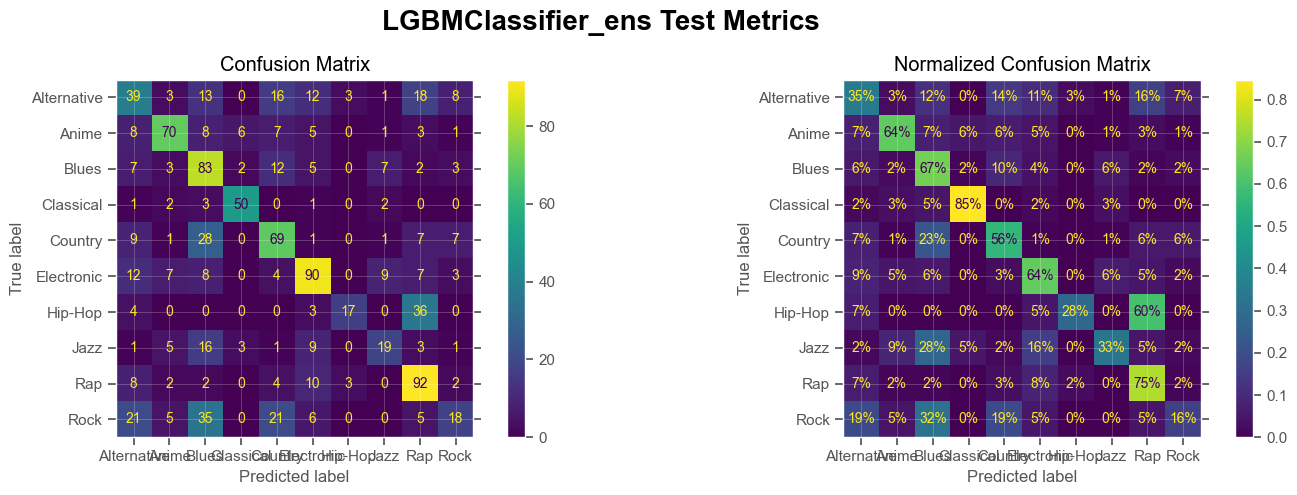


 LGBMClassifier_ens Classification Report: 
               precision    recall  f1-score   support

 Alternative       0.35      0.35      0.35       113
       Anime       0.71      0.64      0.68       109
       Blues       0.42      0.67      0.52       124
   Classical       0.82      0.85      0.83        59
     Country       0.51      0.56      0.54       123
  Electronic       0.63      0.64      0.64       140
     Hip-Hop       0.74      0.28      0.41        60
        Jazz       0.47      0.33      0.39        58
         Rap       0.53      0.75      0.62       123
        Rock       0.42      0.16      0.23       111

    accuracy                           0.54      1020
   macro avg       0.56      0.52      0.52      1020
weighted avg       0.54      0.54      0.52      1020



In [101]:
params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3500,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'verbose': 200,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }

train_pool = Pool(train_ans, target_train) 
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(test_ans,  target_test), plot=True)
make_classification_plots(clf.predict(test_ans), target_test, f'LGBMClassifier_ens')

Text(0.5, 1.0, 'CatBoost Feature Importance')

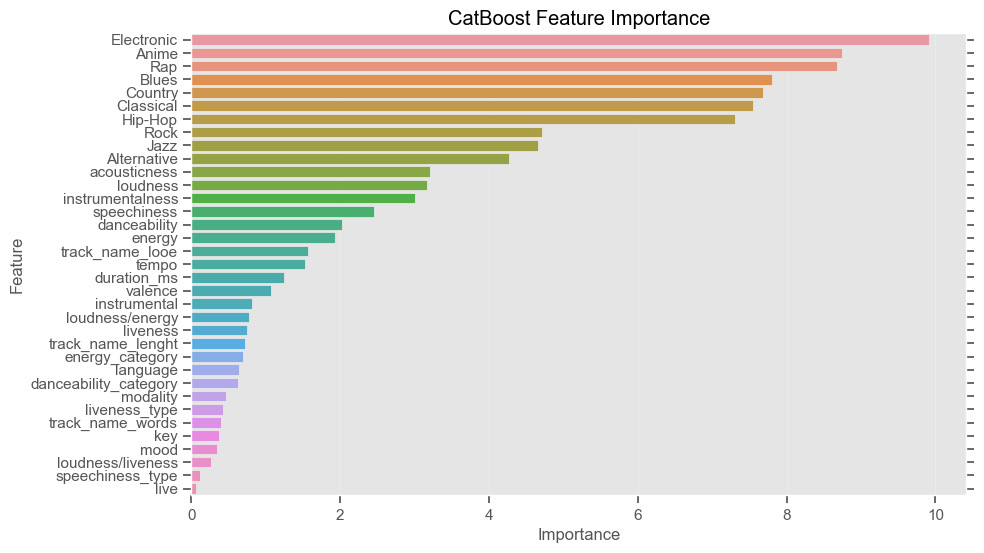

In [51]:
results = list(zip(train_ans, clf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
se.barplot(x = importance.Importance, y = importance.Feature)
plt.title("CatBoost Feature Importance")

#### Create Submition

In [102]:
test1 = test.copy()
test1.drop(columns='track_name', inplace=True)
test1.set_index('instance_id', drop=True, inplace=True)

In [103]:
answer = classes_predict(test1, y_train, model_dict_LGBM)

In [104]:
answer = pd.DataFrame(clf.predict(answer))
answer.index = test1.index
answer.columns = ['music_genre']

In [105]:
answer.to_csv('16.csv')

### Сложение двух ансамблей

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_train2, y_train2, 
                                                    test_size=0.1, random_state=42, shuffle=True)

In [143]:
train_catboost = classes_predict(X_train, y_train, model_dict, pref='cat')
test_catboost = classes_predict(X_test, y_test, model_dict, pref='cat')

In [144]:
train_lgbm = classes_predict(X_train, y_train, model_dict_LGBM, pref='lgbm')
test_lgbm = classes_predict(X_test, y_test, model_dict_LGBM, pref='lgbm')

In [154]:
train_sum = pd.concat([train_catboost.reset_index(drop=True), train_lgbm.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
test_sum = pd.concat([test_catboost.reset_index(drop=True), test_lgbm.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

In [155]:
train_sum = train_sum.T.drop_duplicates().T
test_sum = test_sum.T.drop_duplicates().T

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3300280	test: 0.3360044	best: 0.3360044 (0)	total: 194ms	remaining: 11m 18s
200:	learn: 0.4499681	test: 0.4439425	best: 0.4439425 (196)	total: 39.6s	remaining: 10m 50s
400:	learn: 0.4961693	test: 0.4789369	best: 0.4827977 (347)	total: 1m 19s	remaining: 10m 11s
600:	learn: 0.5089139	test: 0.4861142	best: 0.4875425 (530)	total: 1m 58s	remaining: 9m 33s
800:	learn: 0.5177052	test: 0.5024857	best: 0.5034836 (775)	total: 2m 38s	remaining: 8m 53s
1000:	learn: 0.5246263	test: 0.5068313	best: 0.5068313 (974)	total: 3m 17s	remaining: 8m 13s
1200:	learn: 0.5281929	test: 0.5101740	best: 0.5113062 (1161)	total: 3m 57s	remaining: 7m 35s
1400:	learn: 0.5344548	test: 0.5115581	best: 0.5117732 (1356)	total: 4m 37s	remaining: 6m 56s
1600:	learn: 0.5411614	test: 0.5099005	best: 0.5123993 (1420)	total: 5m 18s	remaining: 6m 17s
1800:	learn: 0.5496004	test: 0.5165351	best: 0.5168944 (1727)	total: 5m 58s	remaining: 5m 38s
2000:	learn: 0.5581894	test: 0.5156026	best: 0.5176276 (1816)	total: 6m 38

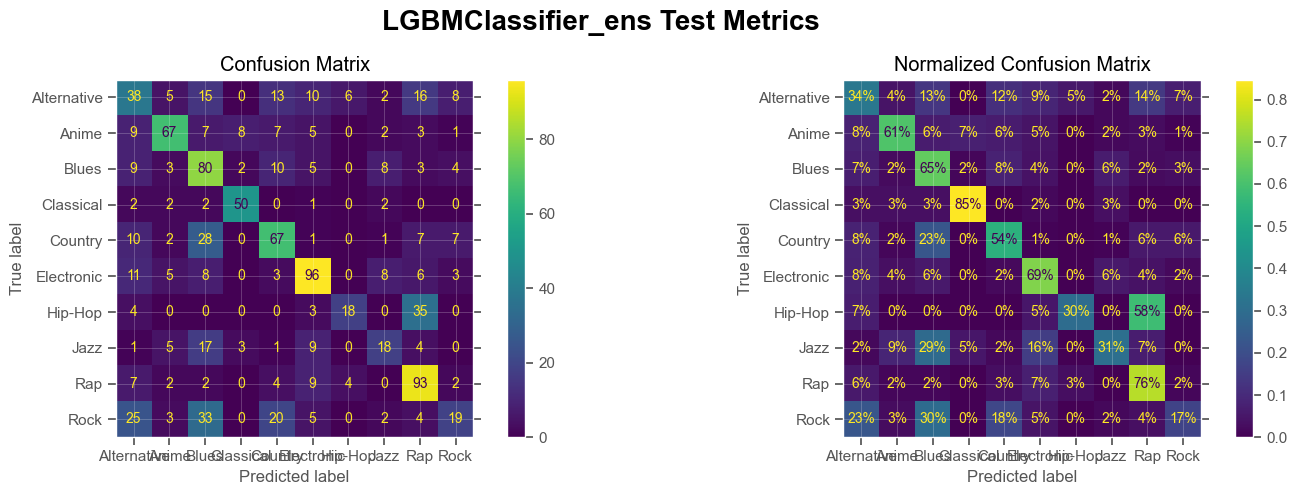


 LGBMClassifier_ens Classification Report: 
               precision    recall  f1-score   support

 Alternative       0.33      0.34      0.33       113
       Anime       0.71      0.61      0.66       109
       Blues       0.42      0.65      0.51       124
   Classical       0.79      0.85      0.82        59
     Country       0.54      0.54      0.54       123
  Electronic       0.67      0.69      0.68       140
     Hip-Hop       0.64      0.30      0.41        60
        Jazz       0.42      0.31      0.36        58
         Rap       0.54      0.76      0.63       123
        Rock       0.43      0.17      0.25       111

    accuracy                           0.54      1020
   macro avg       0.55      0.52      0.52      1020
weighted avg       0.54      0.54      0.52      1020



In [160]:
params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3500,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'verbose': 200,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }

train_pool = Pool(train_sum, target_train) 
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(test_sum,  target_test), plot=True)
make_classification_plots(clf.predict(test_sum), target_test, f'LGBMClassifier_ens')

#### Create Submition

In [102]:
test1 = test.copy()
test1.drop(columns='track_name', inplace=True)
test1.set_index('instance_id', drop=True, inplace=True)

In [162]:
answer_LGBM = classes_predict(test1, y_train, model_dict, pref='cat')
answer_catboost = classes_predict(test1, y_train, model_dict_LGBM, pref='lgbm')

In [167]:
test_sum = pd.concat([answer_catboost.reset_index(drop=True), answer_LGBM.reset_index(drop=True), test1.reset_index(drop=True)], axis=1)

In [169]:
test_sum = test_sum.T.drop_duplicates().T

In [170]:
answer = pd.DataFrame(clf.predict(test_sum))
answer.index = test1.index
answer.columns = ['music_genre']

In [171]:
answer.to_csv('18.csv')

In [172]:
answer

music_genre
instance_id             
48564                Rap
72394              Blues
88081                Rap
78331            Country
72636        Alternative
...                  ...
50532            Country
26255                Rap
67924                Rap
79778         Electronic
47986               Jazz

[5099 rows x 1 columns]

## All vs All

In [179]:
train, target, test, labelencoder = get_good_data()

le = LabelEncoder()
looe = LeaveOneOutEncoder()
pt = PowerTransformer(copy=False)
rs = RobustScaler()

for col in cat_features+['danceability_category', 'energy_category']:
    train[col]  = le.fit_transform(train[col])
    test[col]  = le.transform(test[col])

    
target = le.fit_transform(target)

train['track_name']= looe.fit_transform(train['track_name'], target)
test['track_name']= looe.transform(test['track_name'])

train[skewedFeatures] = pt.fit_transform(train[skewedFeatures])
test[skewedFeatures] = pt.transform(test[skewedFeatures])

train[skewedFeatures] = rs.fit_transform(train[skewedFeatures])
test[skewedFeatures] = rs.transform(test[skewedFeatures])

In [180]:
target = labelencoder.inverse_transform(target)
target = pd.get_dummies(target)

In [181]:
columns = target.columns

In [182]:
def to_binary(data, target, class1, class2):
    good_index = target[(target[class1] == 1) | (target[class2] == 1)].index
    data = data.loc[good_index]
    target = target.loc[good_index][[class1, class2]]
    target = target.idxmax(axis=1)
    le = LabelEncoder()
    target = le.fit_transform(target)
    return data, target, le

In [183]:
def to_binary_test(data, target, class1, class2):
    target = target[[class1, class2]]
    target = target.idxmax(axis=1)
    display(target)
    le = LabelEncoder()
    target = le.fit_transform(target)
    return data, target, le

In [195]:
X_Train_1, X_Train_2, y_train_1, y_test_2 = train_test_split(train, target, 
                                                    test_size=0.4, random_state=42, shuffle=True)

In [209]:
pvp_result = {}
LabelEncoders = {}

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        print(columns[i], columns[j])
        
        train_data, tar_train, le = to_binary(X_Train_1.copy(), y_train_1.copy(), columns[i], columns[j])
        train_data, tar_train  = BorderlineSMOTE().fit_resample(train_data, tar_train)
        LabelEncoders[f'{columns[i]}_vs_{columns[j]}'] = le
        
        LGBM = lgb.LGBMClassifier(random_state=42, learning_rate=0.01, n_estimators=4000)
    

        grid = GridSearchCV(estimator= LGBM,
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf']}, cv=3, scoring='f1_micro')

        grid.fit(train_data, tar_train)
        print(grid.best_score_)
        
        print(grid.best_estimator_)
        pvp_result[f'{columns[i]}_vs_{columns[j]}'] = grid
        
        

Alternative Anime
0.8224769670655512
LGBMClassifier(learning_rate=0.01, n_estimators=4000, random_state=42)
Alternative Blues
0.7862529483735069
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Classical
0.9618073940720345
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Country
0.8074584936519704
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Electronic
0.8137159212585453
LGBMClassifier(learning_rate=0.01, n_estimators=4000, random_state=42)
Alternative Hip-Hop
0.8682057255815595
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Jazz
0.8954431265958324
LGBMClassifier(boosting_type='goss', learning_rate=0.01, n_estimators=4000,
               random_state=42)
Alternative Rap
0.8180936496170003
LGBMClassifi

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X_Train_2, y_test_2, 
                                                    test_size=0.1, random_state=42, shuffle=True)

#X_train, y_train = use_upscaling(X_train, y_train)

In [211]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [212]:
pred_train = []
pred_test = []
res_columns = []

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        res_columns.append(f'{columns[i]}_vs_{columns[j]}')
        pred_test.append(pvp_result[f'{columns[i]}_vs_{columns[j]}'].predict_proba(X_test)[:,1].T)
        pred_train.append(pvp_result[f'{columns[i]}_vs_{columns[j]}'].predict_proba(X_train)[:,1].T)



In [213]:
train_ens = pd.DataFrame(np.array(pred_train).T)
test_ens = pd.DataFrame(np.array(pred_test).T)

In [214]:
train_ens = pd.concat([train_ens, X_train], axis=1)
test_ens = pd.concat([test_ens.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

In [215]:
target_train = y_train.idxmax(axis=1)
target_test = y_test.idxmax(axis=1)

In [217]:
params = {
        'boosting_type': 'Ordered',
        'max_depth': 6,
        'n_estimators':3000,
        'learning_rate': 0.01,
        'thread_count': -1,
        'l2_leaf_reg': 3.0,
        'random_state': 42,
        'verbose': 500,
        'custom_metric': ['AUC', 'Accuracy'],
        'eval_metric' : 'TotalF1:average=Macro',
        'use_best_model': True
    }

train_pool = Pool(train_ens,  target_train)
clf = CatBoostClassifier(**params)
clf.fit(train_pool, eval_set=(test_ens,  target_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3143973	test: 0.3180269	best: 0.3180269 (0)	total: 326ms	remaining: 16m 16s
500:	learn: 0.5019676	test: 0.4732697	best: 0.4732697 (496)	total: 2m 58s	remaining: 14m 47s
1000:	learn: 0.5326852	test: 0.4827122	best: 0.4831618 (782)	total: 5m 52s	remaining: 11m 44s
1500:	learn: 0.5543505	test: 0.4919980	best: 0.4923013 (1481)	total: 8m 54s	remaining: 8m 54s
2000:	learn: 0.5813097	test: 0.4925295	best: 0.4955402 (1546)	total: 12m 1s	remaining: 5m 59s
2500:	learn: 0.6040160	test: 0.4989287	best: 0.4992928 (2418)	total: 15m 9s	remaining: 3m 1s
2999:	learn: 0.6275933	test: 0.5048340	best: 0.5048340 (2969)	total: 18m 20s	remaining: 0us

bestTest = 0.5048339872
bestIteration = 2969

Shrink model to first 2970 iterations.


[Summary Statistics]
Accuracy = 53.55% | Balanced Accuracy = 51.15% | Precision = 53.47% | Recall = 53.55% | F1-Score = 51.77% | fbeta = 52.05%


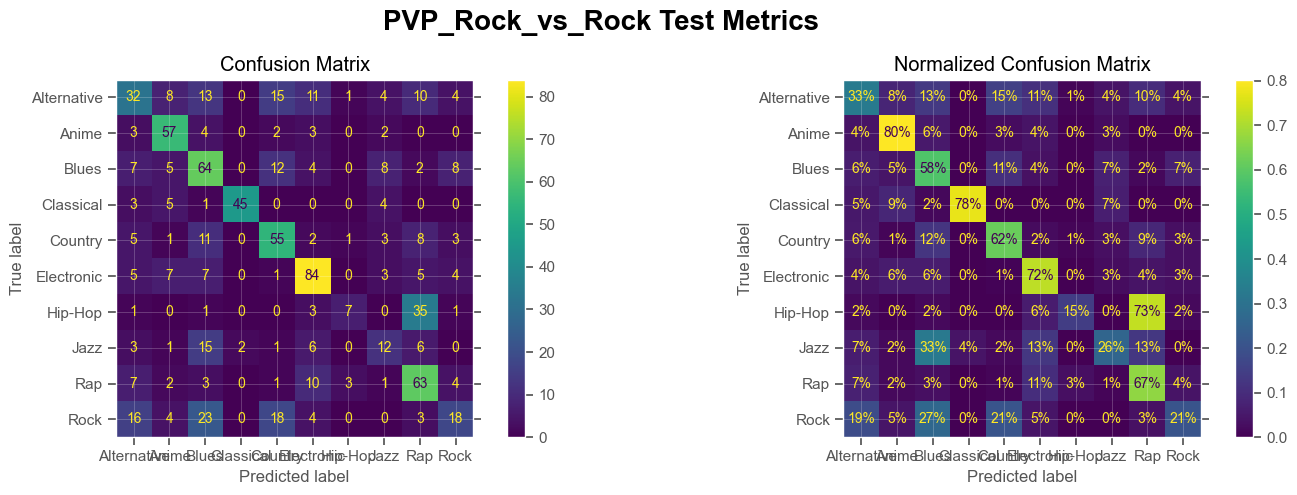


 PVP_Rock_vs_Rock Classification Report: 
               precision    recall  f1-score   support

 Alternative       0.39      0.33      0.36        98
       Anime       0.63      0.80      0.71        71
       Blues       0.45      0.58      0.51       110
   Classical       0.96      0.78      0.86        58
     Country       0.52      0.62      0.57        89
  Electronic       0.66      0.72      0.69       116
     Hip-Hop       0.58      0.15      0.23        48
        Jazz       0.32      0.26      0.29        46
         Rap       0.48      0.67      0.56        94
        Rock       0.43      0.21      0.28        86

    accuracy                           0.54       816
   macro avg       0.54      0.51      0.50       816
weighted avg       0.53      0.54      0.52       816



In [220]:
make_classification_plots(clf.predict(test_ens), target_test, f'PVP_{columns[i]}_vs_{columns[j]}')

Text(0.5, 1.0, 'All vs All Feature Importance')

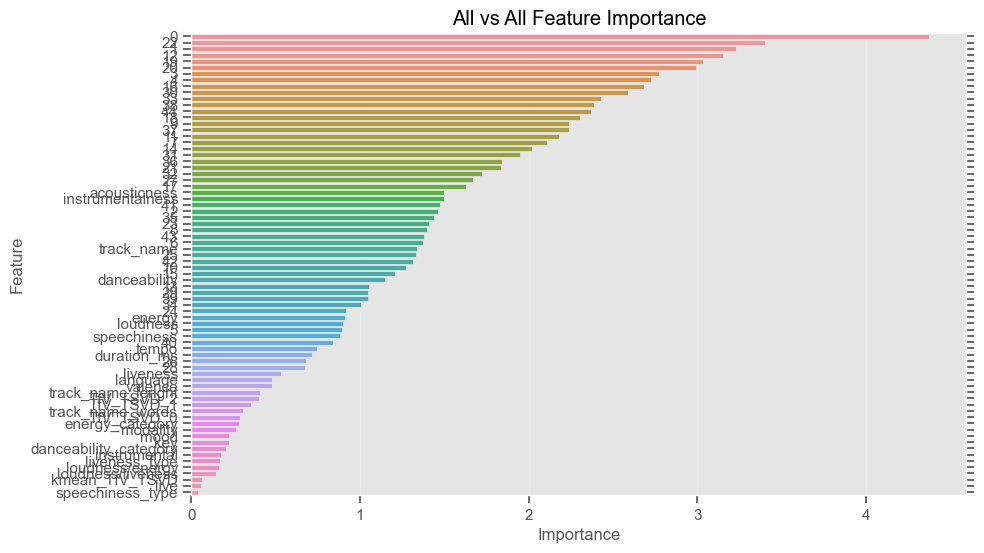

In [221]:
results = list(zip(train_ens, clf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
se.barplot(x = importance.Importance, y = importance.Feature)
plt.title("All vs All Feature Importance")

### Creat Submition

In [232]:
test1 = test.copy()

In [224]:
test1.set_index('instance_id', drop=True, inplace=True)

In [225]:
pred_test = []
res_columns = []

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        res_columns.append(f'{columns[i]}_vs_{columns[j]}')
        pred_test.append(pvp_result[f'{columns[i]}_vs_{columns[j]}'].predict_proba(test1)[:,1].T)

In [226]:
test_ens = pd.DataFrame(np.array(pred_test).T)

In [227]:
test_ens.index = test1.index

In [228]:
test1 = pd.concat([test_ens, test1], axis=1)

In [229]:
answer = pd.DataFrame(clf.predict(test1))
answer.index = test1.index
answer.columns = ['music_genre']

In [230]:
answer.to_csv("14.csv")

In [231]:
answer

music_genre
instance_id             
48564                Rap
72394              Blues
88081                Rap
78331            Country
72636        Alternative
...                  ...
50532            Country
26255                Rap
67924                Rap
79778         Electronic
47986              Blues

[5099 rows x 1 columns]

## StackingClassifier

In [602]:
train_ens.columns = train_ens.columns.astype(str)
test_ens.columns = test_ens.columns.astype(str)

In [174]:
gb = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_estimators=100)

lgbm = LGBMClassifier(random_state=0, learning_rate=0.01, n_estimators=4000, num_leaves=10)

cat = CatBoostClassifier(n_estimators=2000, learning_rate=0.01, random_state=0, eval_metric= 'TotalF1:average=Macro')

In [197]:
estimators = [
              ('gb', gb),
              ('lgbm', lgbm),
              ('cat', cat),
             ]

stack_model = StackingClassifier(estimators=estimators, final_estimator = lr
                                 ,n_jobs =-1, verbose = False, passthrough=True)

stack_model.fit(train_ans, target_train)

StackingClassifier(estimators=[('gb',
                                GradientBoostingClassifier(random_state=0)),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.01,
                                               n_estimators=4000, num_leaves=10,
                                               random_state=0)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001EF1085FD00>)],
                   final_estimator=LogisticRegression(C=10, max_iter=500,
                                                      random_state=0,
                                                      solver='newton-cg'),
                   n_jobs=-1, passthrough=True, verbose=False)

[Summary Statistics]
Accuracy = 52.94% | Balanced Accuracy = 51.83% | Precision = 54.32% | Recall = 52.94% | F1-Score = 52.06% | fbeta = 52.88%


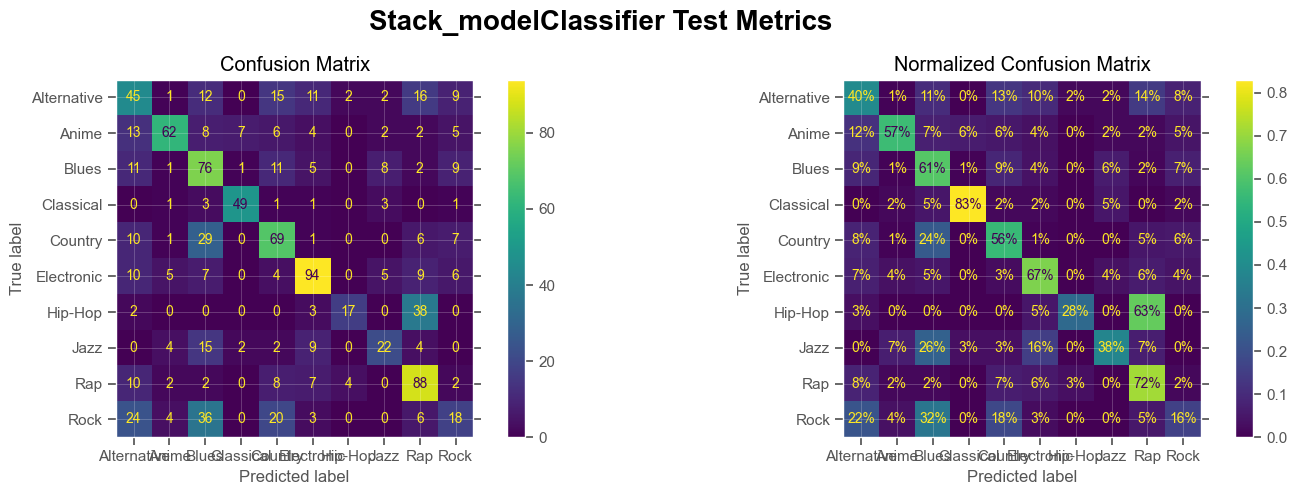


 Stack_modelClassifier Classification Report: 
               precision    recall  f1-score   support

 Alternative       0.36      0.40      0.38       113
       Anime       0.77      0.57      0.65       109
       Blues       0.40      0.61      0.49       124
   Classical       0.83      0.83      0.83        59
     Country       0.51      0.56      0.53       123
  Electronic       0.68      0.67      0.68       140
     Hip-Hop       0.74      0.28      0.41        60
        Jazz       0.52      0.38      0.44        58
         Rap       0.51      0.72      0.60       123
        Rock       0.32      0.16      0.21       111

    accuracy                           0.53      1020
   macro avg       0.56      0.52      0.52      1020
weighted avg       0.54      0.53      0.52      1020



In [198]:
make_classification_plots(stack_model.predict(test_ans), target_test, 'Stack_modelClassifier')

#### Create Submition

In [203]:
test1 = test.copy()
test1.drop(columns='track_name', inplace=True)
test1.set_index('instance_id', drop=True, inplace=True)

In [204]:
test_ans = classes_predict(test1, y_train, model_dict_LGBM)

In [205]:
stack_model.predict(test_ans)

array(['Rap', 'Blues', 'Rap', ..., 'Rap', 'Electronic', 'Jazz'],
      dtype=object)

In [206]:
answer = pd.DataFrame(stack_model.predict(test_ans))

In [207]:
answer.index = test1.index
answer.columns = ['music_genre']

In [208]:
answer.to_csv('19.csv')

In [209]:
answer

music_genre
instance_id             
48564                Rap
72394              Blues
88081                Rap
78331            Country
72636        Alternative
...                  ...
50532            Country
26255        Alternative
67924                Rap
79778         Electronic
47986               Jazz

[5099 rows x 1 columns]

# Вывод

В данной работе, было необходимо разработать модель для определения жанра музыки по имеющимся характеристикам. Задача относится к задаче многоклассовой класификации. Основная сложность была в генерации новых признаков для увеличения метрики. Использовались следующие модели:

    1)Многоклассовая классификация CatBoost  
    2)One vs All CatBoost  
    3)LGBM классификация  
    4)One vs All LGBM  
    5)One vs All CatBoost + One vs All LGBM  
    6)One vs All LGBM + StackingClassifier  
 
Наилучший разультат показала модель One vs All LGBM с максимальной метрикой 54 на тесте (10% обучающей выборки). Сильный прирост в метрике дало генерация признаков из названия трека: язык, число символов и классификация названия по жанрам. 